In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd
import umap

import sys
sys.path.append('../')
from mySCfunctions import *
from silent import *
sys.path.append('./')

import Parameters as par
from importlib import reload
reload(par);

from sklearn import preprocessing
import pydpc

import os, shutil

import warnings
warnings.filterwarnings('ignore')

In [2]:
s_genes_list = \
    ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
g2m_genes_list = \
    ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

In [3]:
a = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_removed.h5ad")

# Louvain clustering

In [4]:
geneList = [
 'Adh1a2','Cdh1','Cdh2','Cdh11','Cer1','Dlx5','Dmrt2','Ebf1','Egr2','En1','Eomes','Eya1','Eya2','Evx1','Fgf5','Foxa2','Foxc1','Foxd1','Foxf1','Foxf2','Foxp2','Hand1',
 'Hand2','Hesx1','Hoxa1','Hoxa2','Hoxa3','Hoxa4','Hoxa10','Irx3','Isl1','Kdr','Lefty1','Lfng','Lhx1','Meox1','Mesp1','Mesp2','Msc','Msgn','Myf5','Nanog','Nkx2-5','Noto',
 'Olig2','Osr1','Otx2','Pax1','Pax3','Pax6','Pitx2','Prdm1','Pou3f1','Ripply2','Shh','Six1','Six3','Snai1','Snai2','Sox1','Sox2','Sox3','Sox9','Sox17','T','Tfap2a','Tfap2c','Tbx1','Tbx4','Tbx5',
 'Tbx6','Tbx18','Tcf15','Tcf21','Twist1','Twist2','Uncx','Wnt1'
]

Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express
Adh1a2  doesn't express
Msgn  doesn't express


KeyboardInterrupt: 

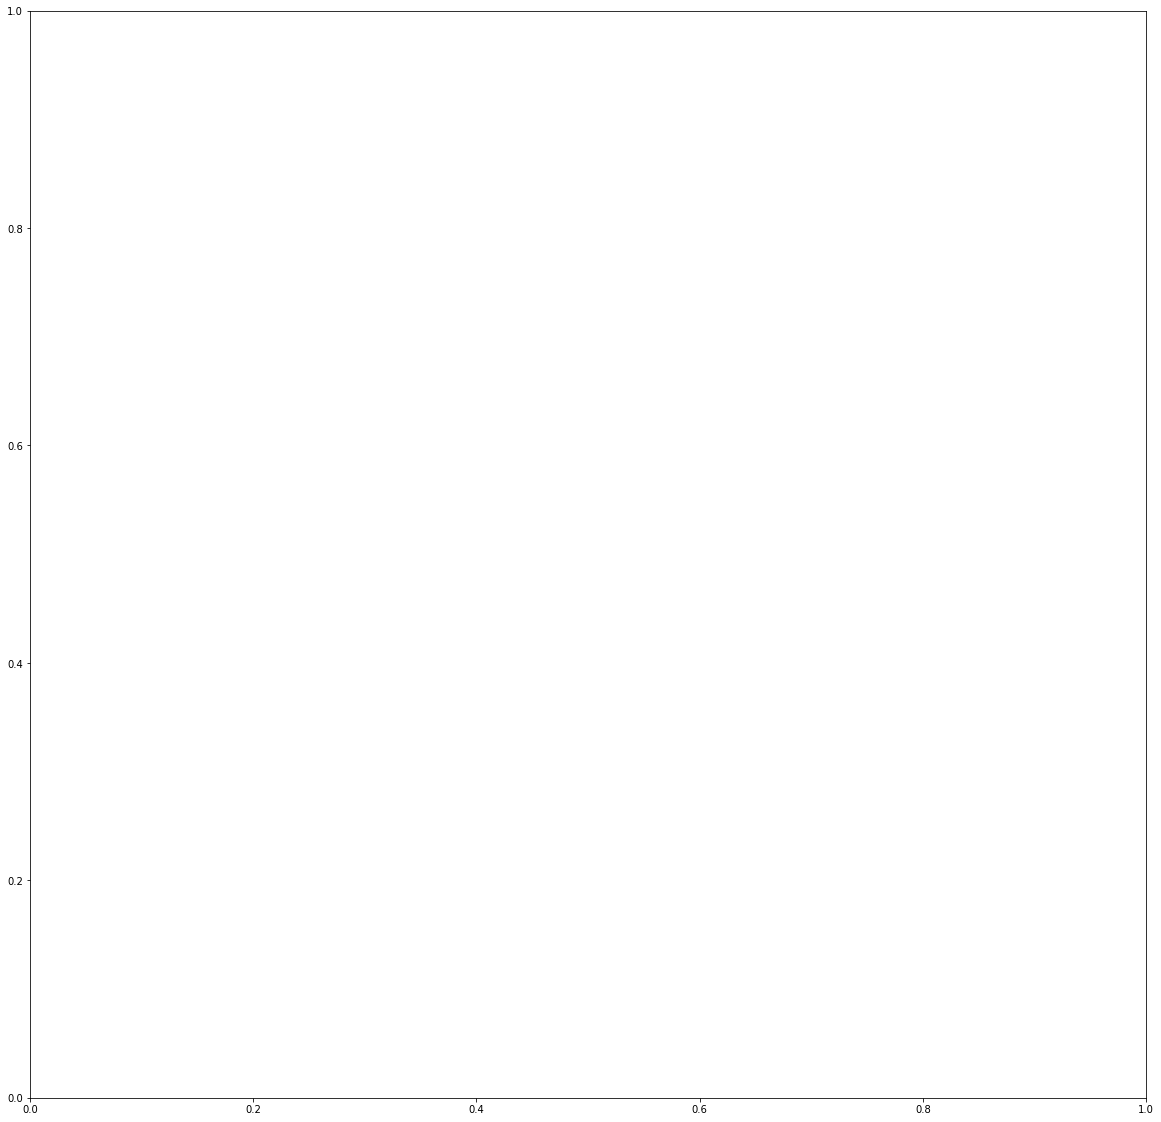

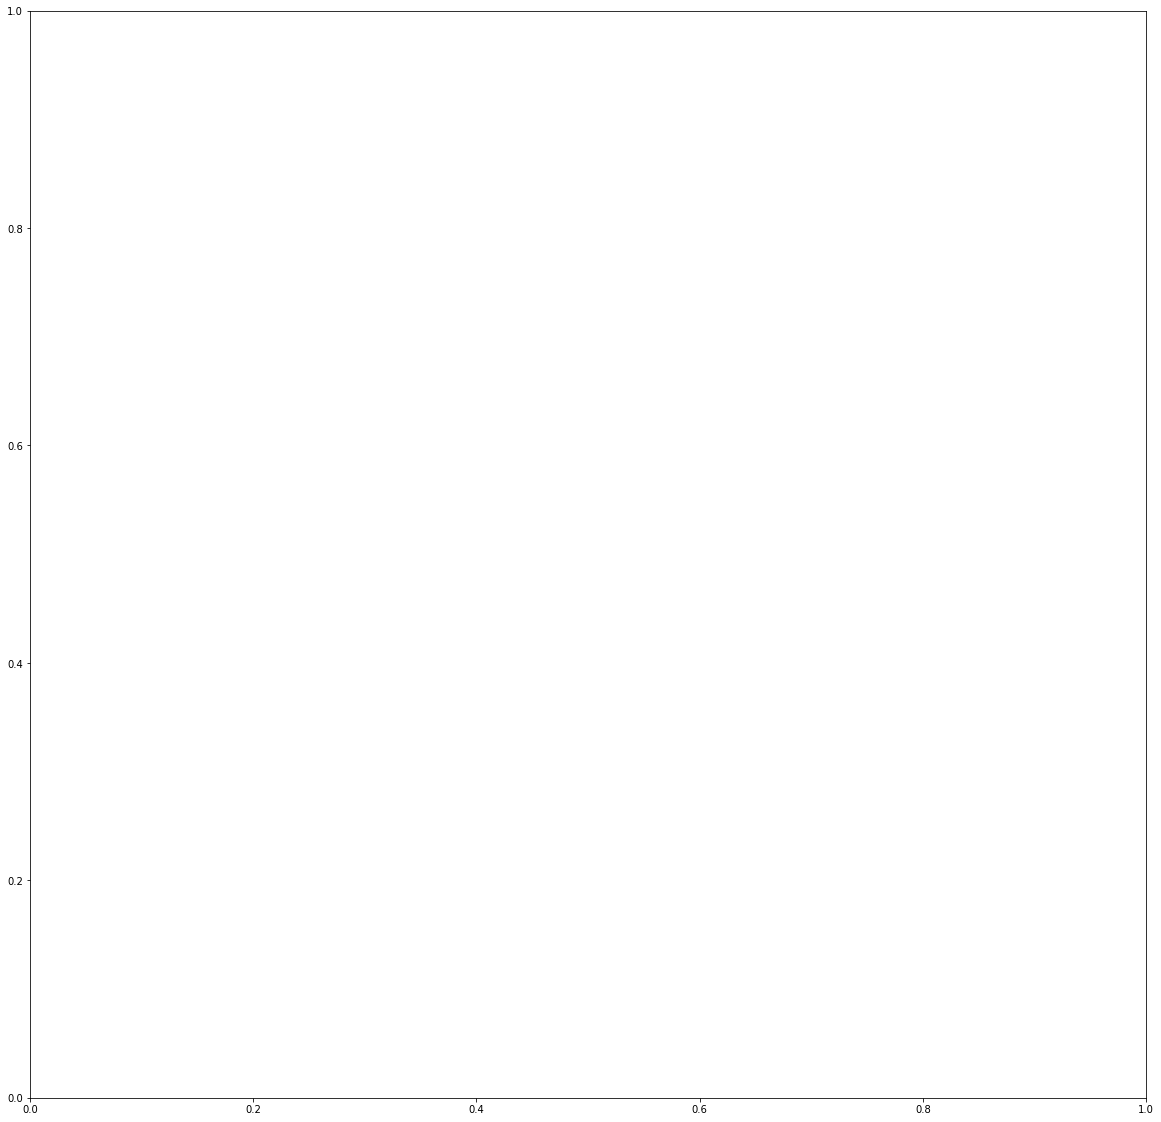

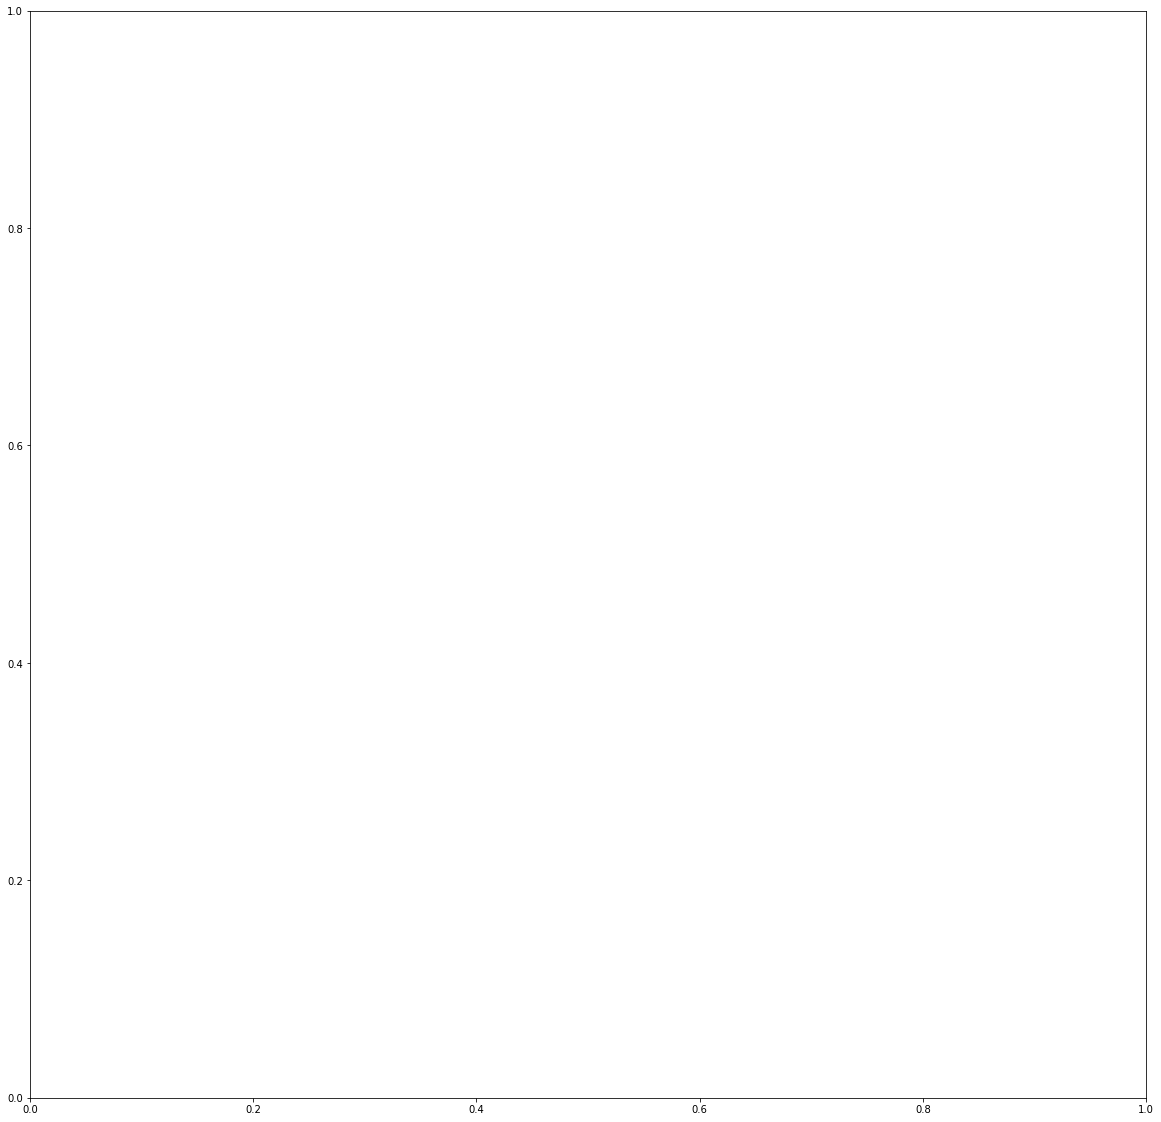

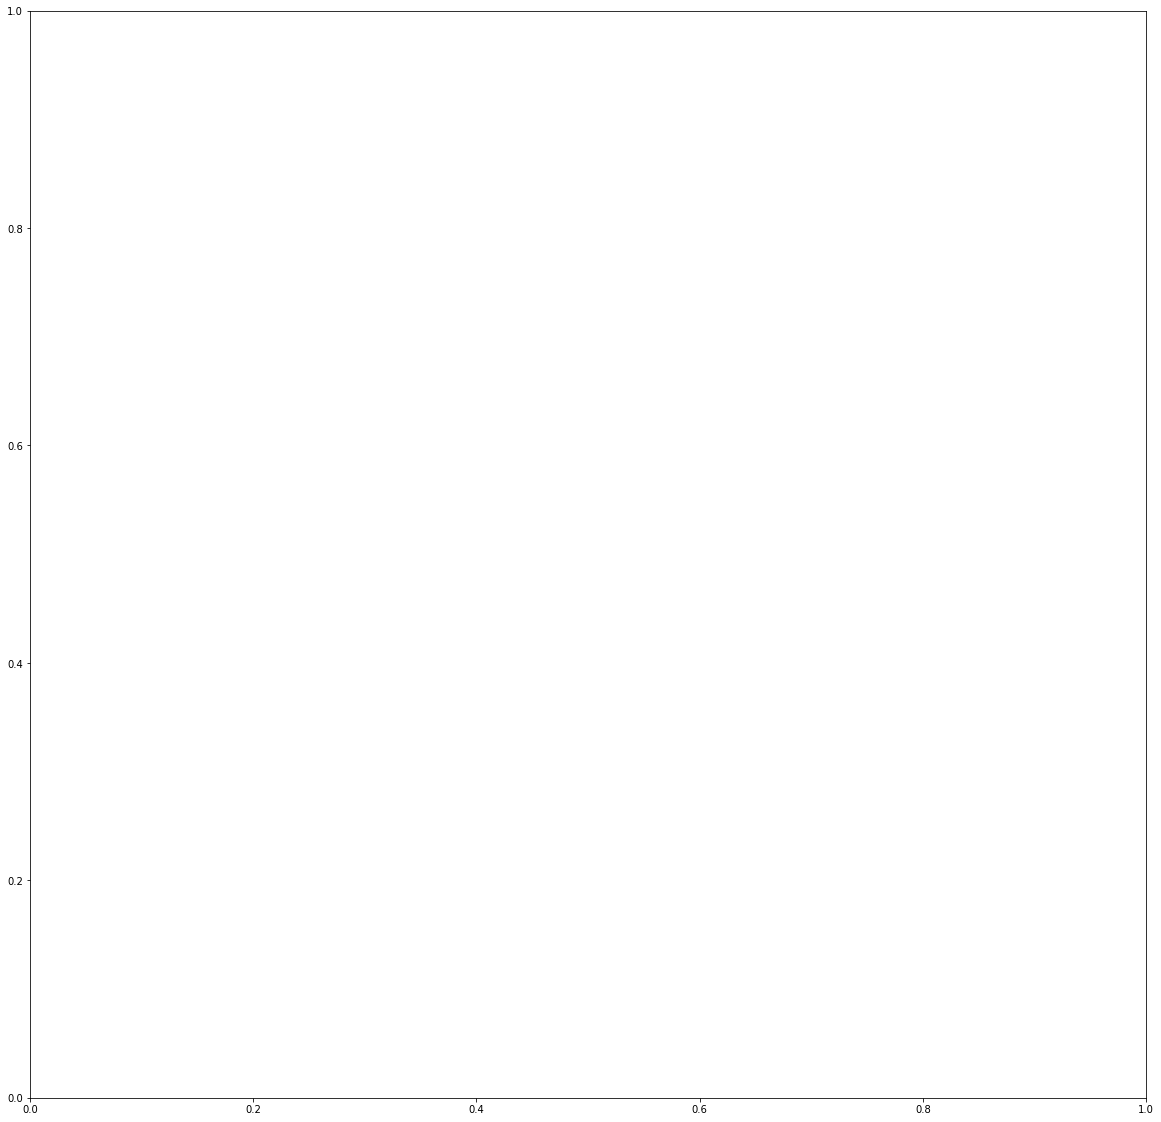

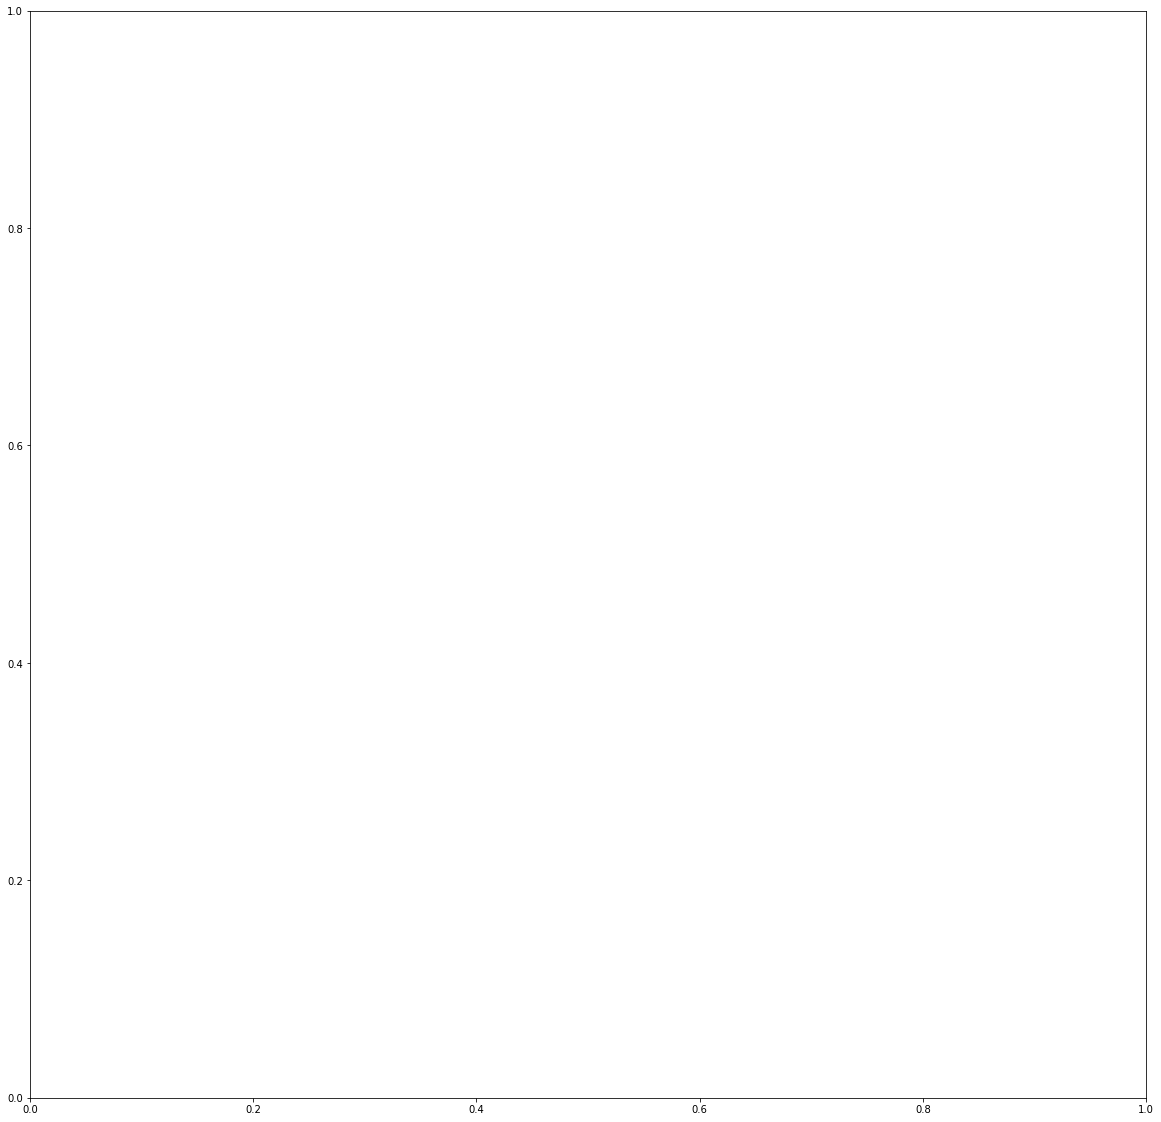

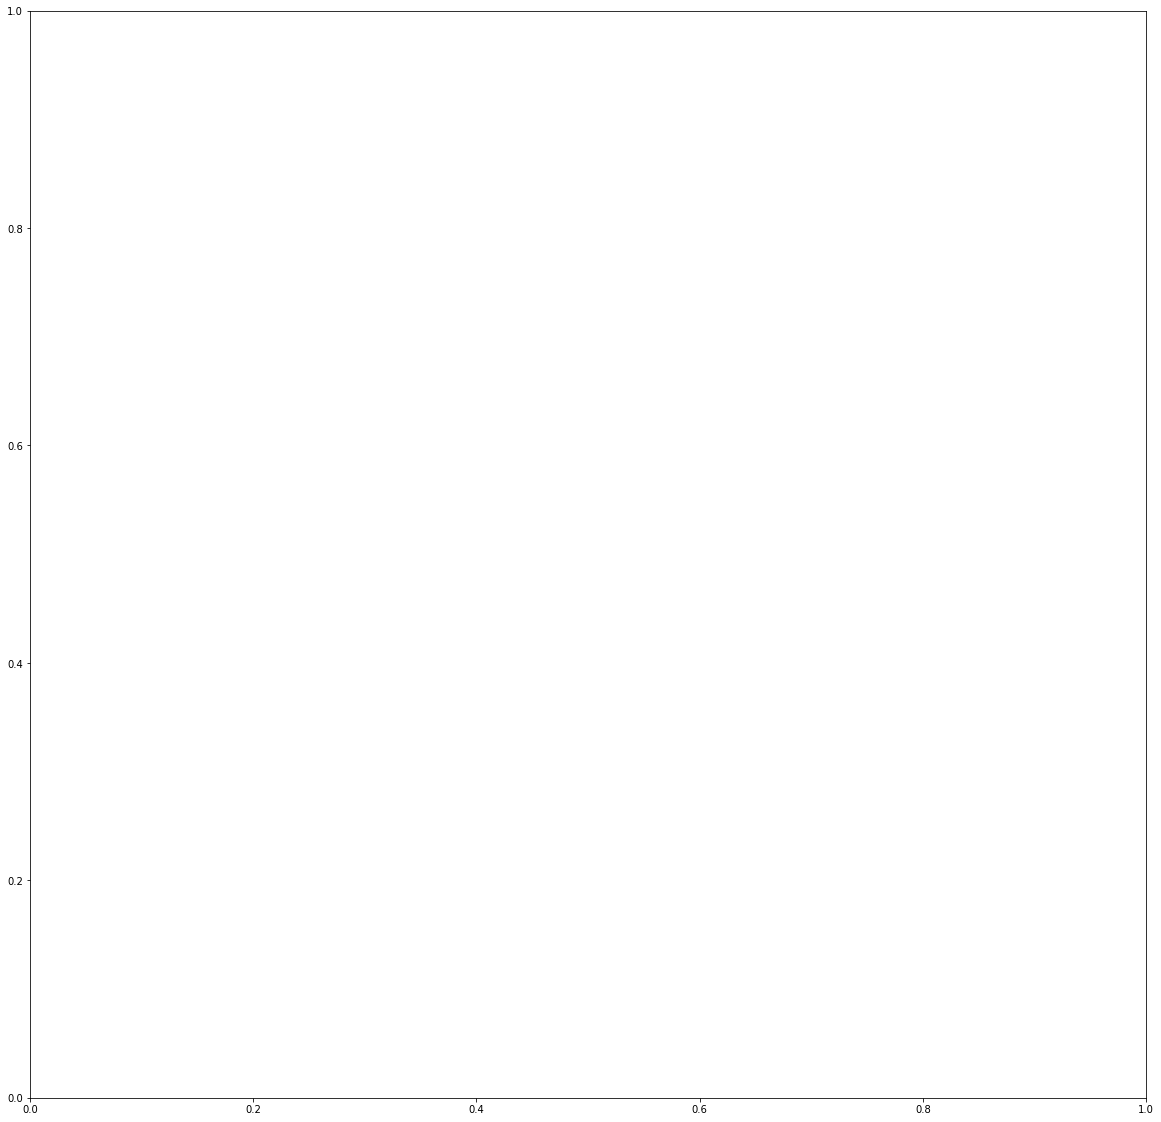

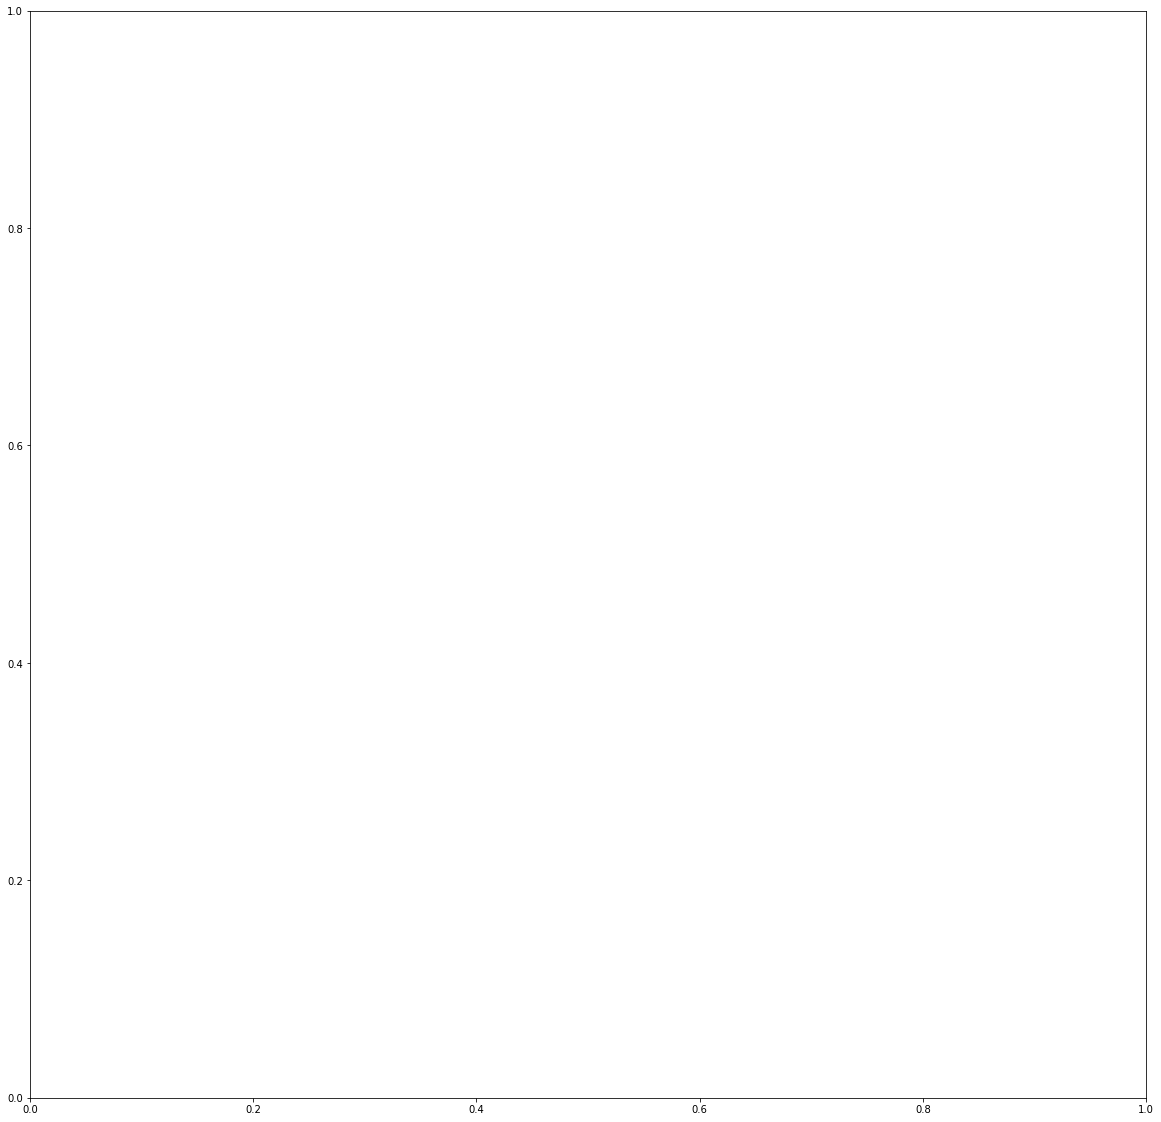

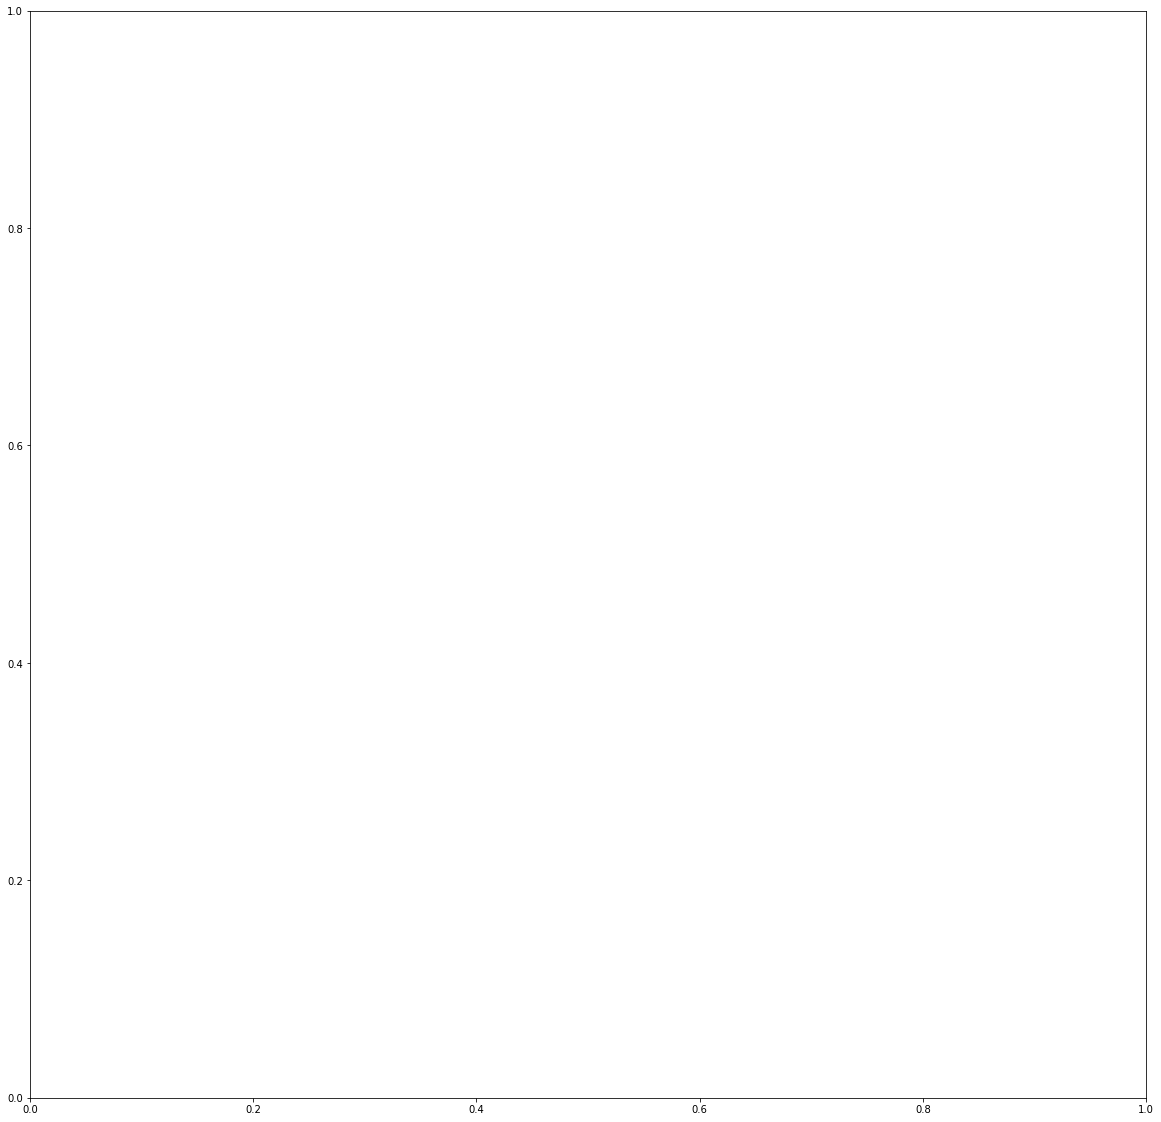

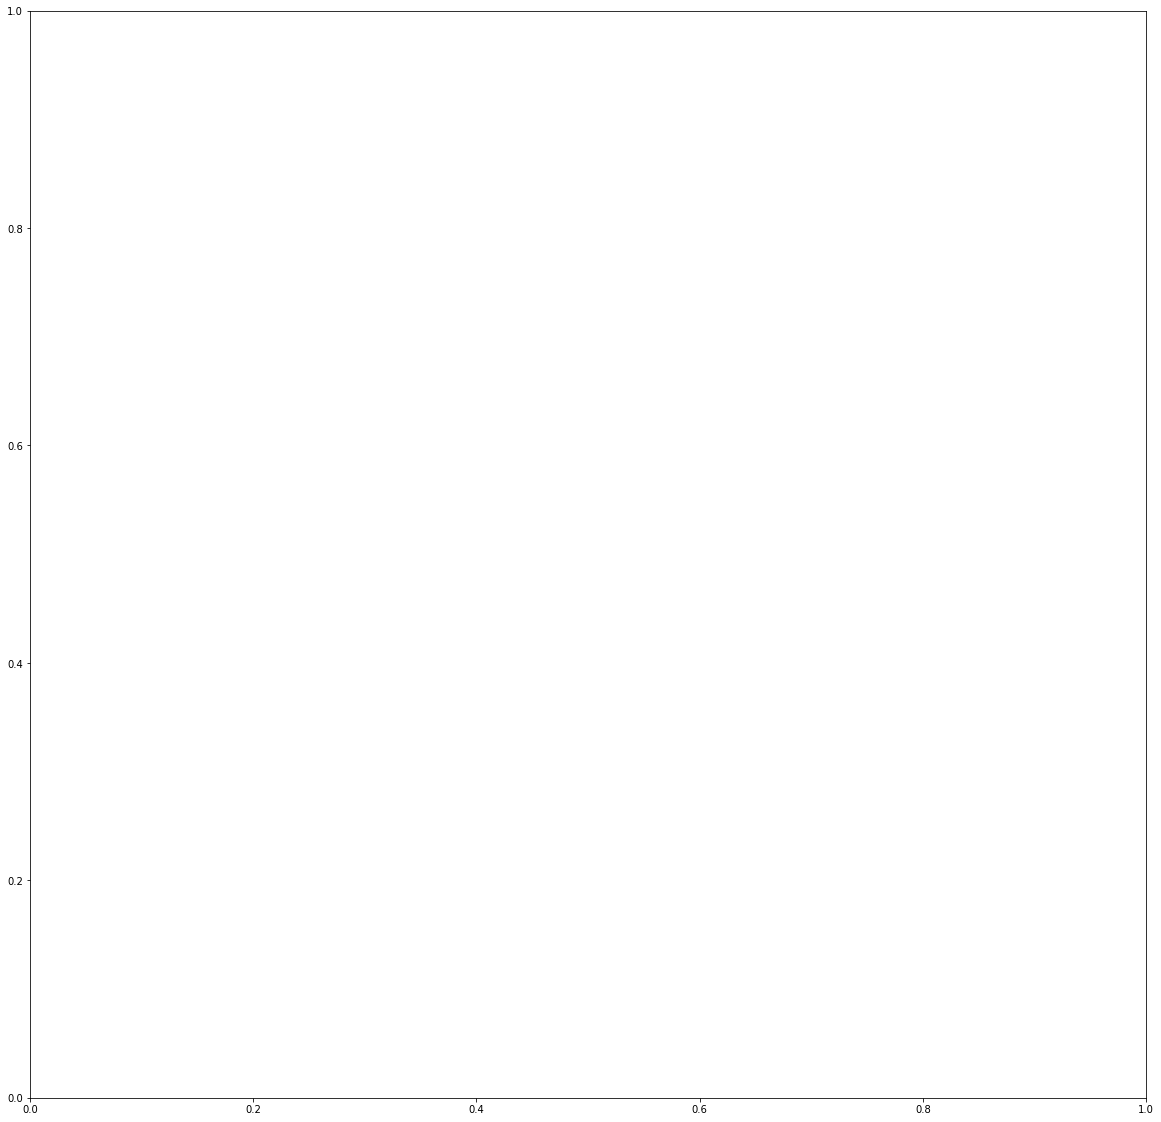

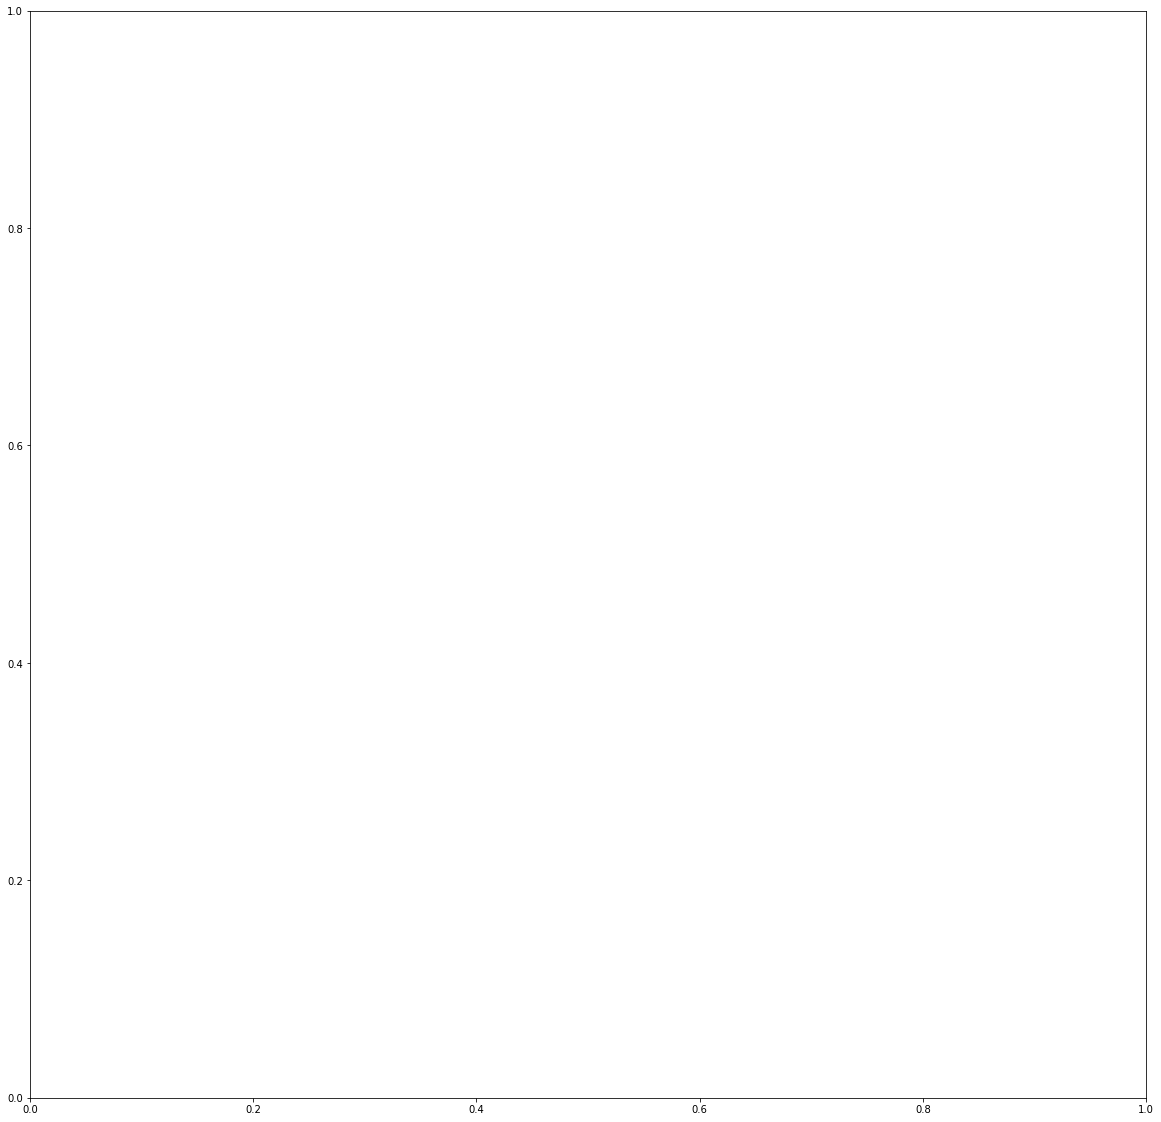

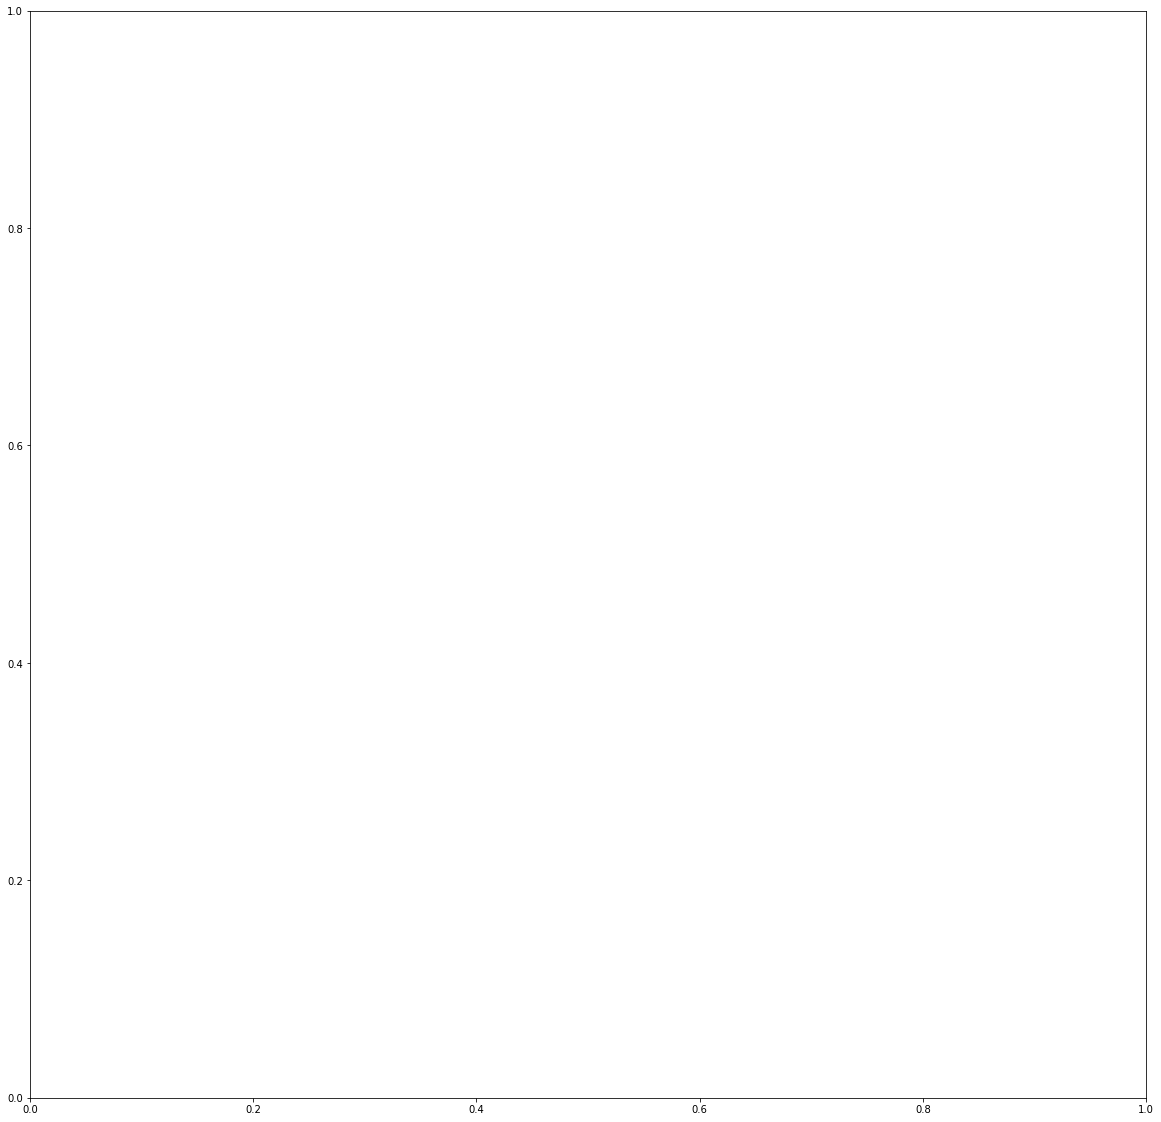

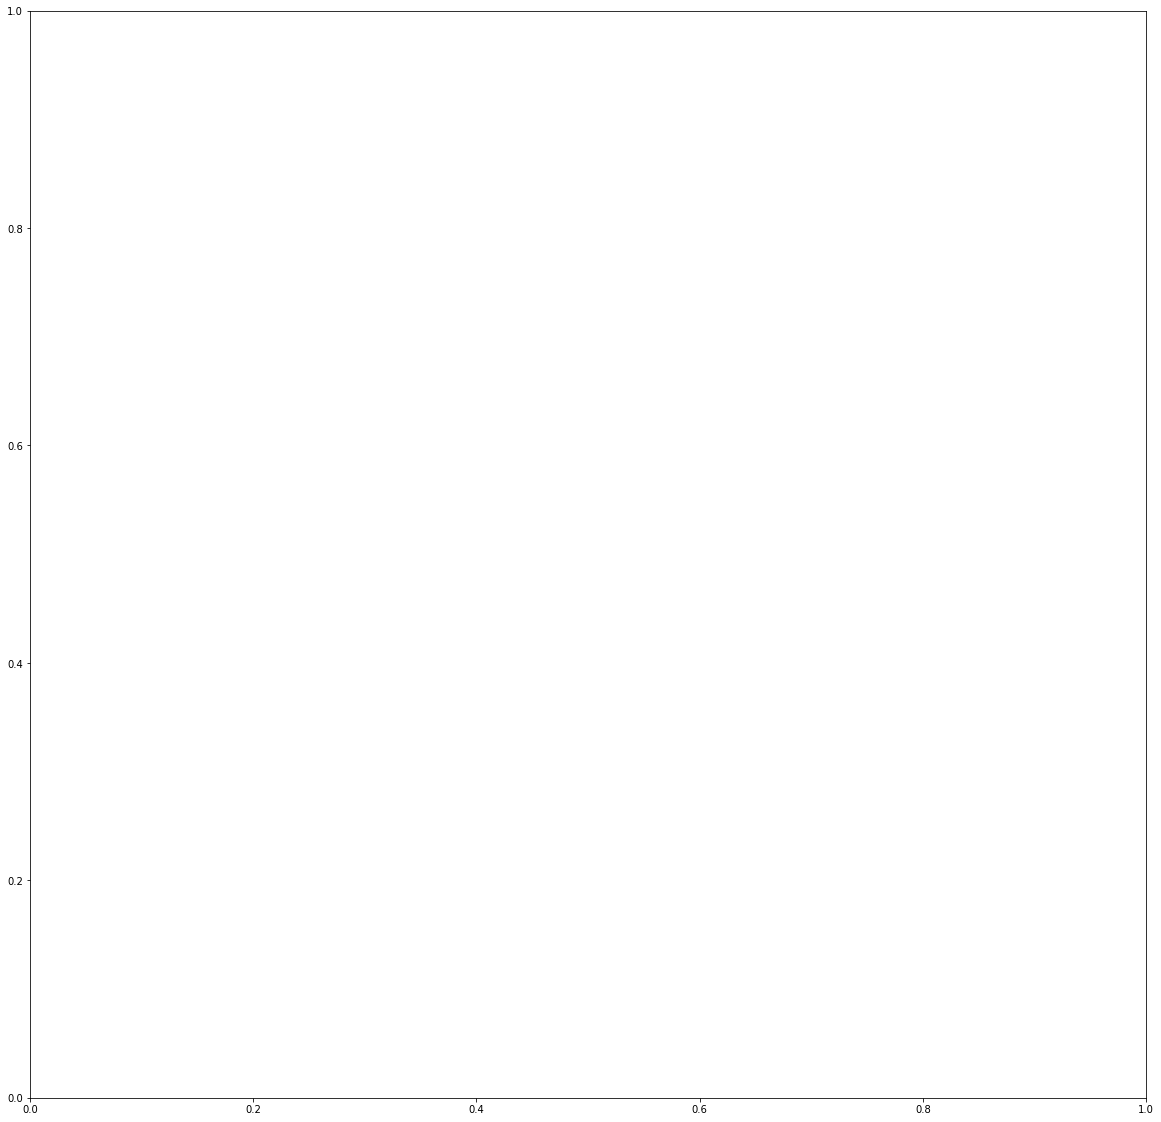

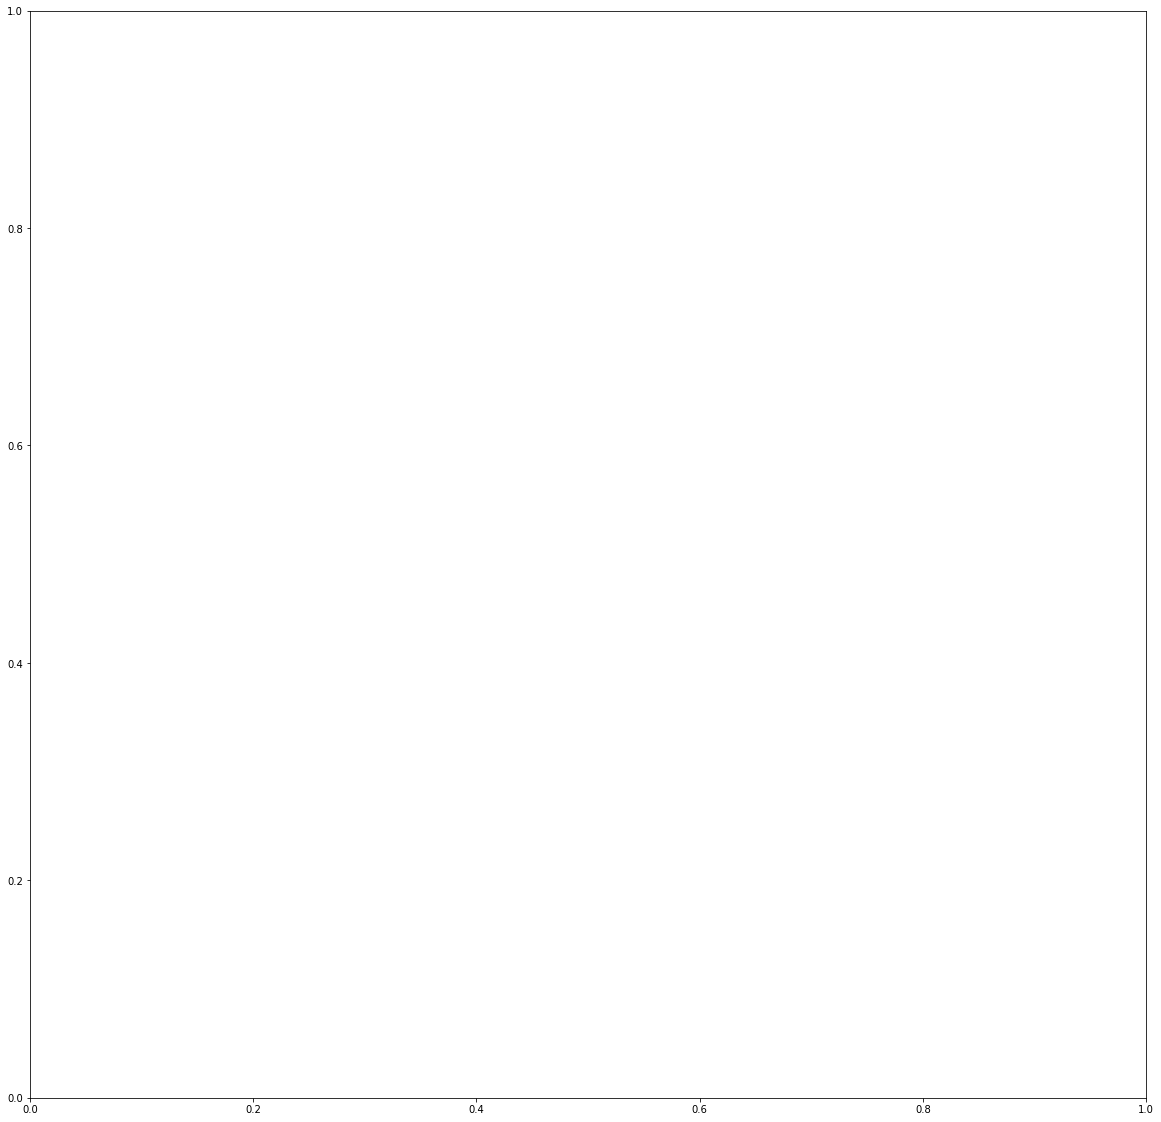

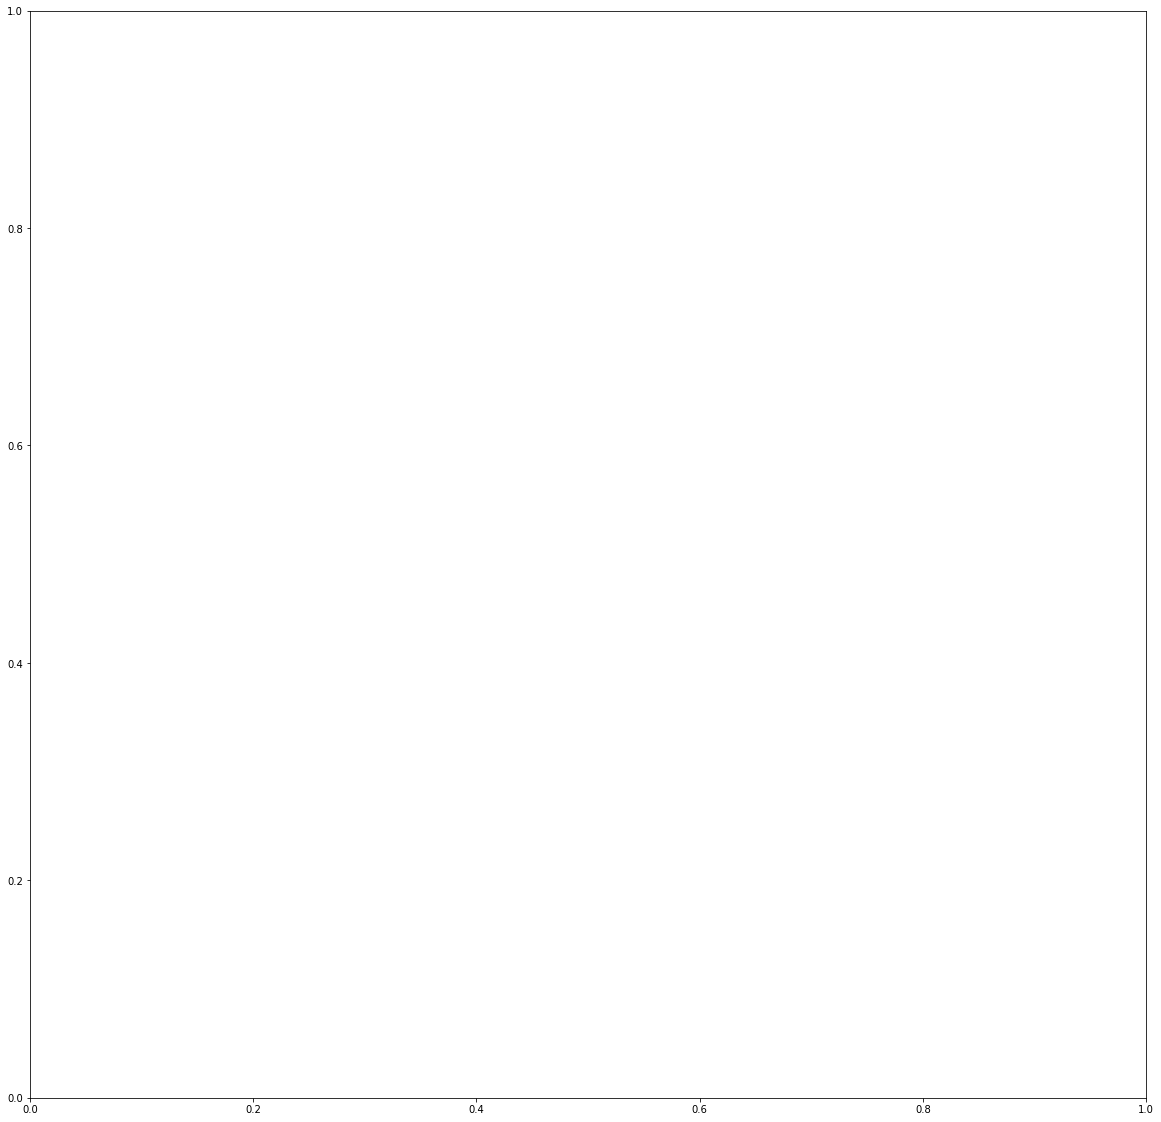

In [12]:
resolution = 1
c = []
for j,i in enumerate(a.obs["stage"].unique()[:]):
    
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")            
    scp.tl.louvain(b,resolution=resolution)
    np.save("./ManipulatedData/"+par.METRIC+"/tables/clusters_louvain_r"+str(resolution)+"_"+i+".npy",b.obs.loc[:,"louvain"].values.astype(str))
    
    #Plot clusters
    fig,ax = plt.subplots(1,1,figsize=[20,20])
    X = b.obsm["X_umap"]
    sb.scatterplot(X[:,0],X[:,1],hue=b.obs.loc[:,"louvain"],s=50,ax=ax)
    ax.set_title(i,fontsize=40)
    for k in b.obs["louvain"].unique():
        pos = b[b.obs["louvain"]==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax.text(pos[0],pos[1],k,fontsize=20,backgroundcolor="grey")
    fig.savefig("./Alfonso/Clustering_"+i+".png",bbox_inches="tight",transparent=False)
    plt.close(fig)
        
    #Rank genes
    d = "./Alfonso/Genes_"+i
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

    scp.tl.rank_genes_groups(b,groupby="louvain",method="wilcoxon",use_raw=False)
    n_genes = 200
    for k,group in enumerate(b.uns["rank_genes_groups"]["names"].dtype.names):
        l = pd.DataFrame(columns=["names","logfoldchanges","pvals","pvals_adj","scores"])
        l.loc[:,"names"] = b.var.loc[[n[k] for n in b.uns["rank_genes_groups"]["names"]][:n_genes],"Gene"].values
        l.loc[:,"logfoldchanges"] = [n[k] for n in b.uns["rank_genes_groups"]["logfoldchanges"]][:n_genes]
        l.loc[:,"pvals"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals"]][:n_genes]
        l.loc[:,"pvals_adj"] = [n[k] for n in b.uns["rank_genes_groups"]["pvals_adj"]][:n_genes]
        l.loc[:,"scores"] = [n[k] for n in b.uns["rank_genes_groups"]["scores"]][:n_genes]
        l.to_csv("./Alfonso/Genes_"+i+"/DEGenes_"+i+"_Cluster_"+group+".csv")
    
    for k in geneList:
        try:
            fig,ax = plt.subplots(1,1,figsize=[20,20])
            hue = b[:,b.var.loc[:,"Gene"]==k].X.toarray()[:,0]
            pos = np.argsort(hue)

            sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
            ax.set_title(k,fontsize=40)
            fig.savefig("./Alfonso/Genes_"+i+"/"+k+".png",bbox_inches="tight",transparent=False)
            plt.close(fig)
        except:
            print(k, " doesn't express")

In [8]:
for j,i in enumerate(a.obs["stage"].unique()[:]):
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")            

    hue = b.obs["celltype"]
    X = b.obsm["X_umap"]
    
    fig,ax = plt.subplots(1,1,figsize=[20,20])

    sb.scatterplot(X[:,0],X[:,1],hue=hue,s=50,ax=ax)
    ax.set_title(i,fontsize=40)
    ax.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.savefig("./Alfonso/Marioni_annotations_"+i+".png",bbox_inches="tight",transparent=False)
    plt.close(fig)    

In [91]:
for j,i in enumerate(a.obs["stage"].unique()[:]):
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")            

    hue = b.obs["celltype"]
    keep = False*np.ones_like(hue).astype(bool)
    for j in np.unique(b.obs["celltype"]):
        l = (b.obs["celltype"] == j)
        if np.sum(l)/len(l) > 0.02:
            None
        else:
            hue.replace(j,"other",inplace=True)
                
    pos = np.argsort(hue)
    X = b.obsm["X_umap"]
    fig,ax = plt.subplots(1,1,figsize=[20,20])

    sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
    ax.set_title(i,fontsize=40)
    
    leg = []
    for l,k in enumerate([ll.get_text() for ll in ax.legend_.texts]):
        pos = b[hue==k,:].obsm["X_umap"]
        pos = np.nan_to_num(pos)
        pos = pos.mean(axis=0)
        ax.text(pos[0],pos[1],l,fontsize=20,backgroundcolor="grey")
        leg.append(str(l)+" "+k)

    ax.legend(leg,fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.savefig("./Alfonso/Marioni_annotations_limited_"+i+".png",bbox_inches="tight",transparent=False)
    plt.close(fig)   

No annotations for : E6.75
No annotations for : E7.75
No annotations for : mixed_gastrulation
No annotations for : E8.25


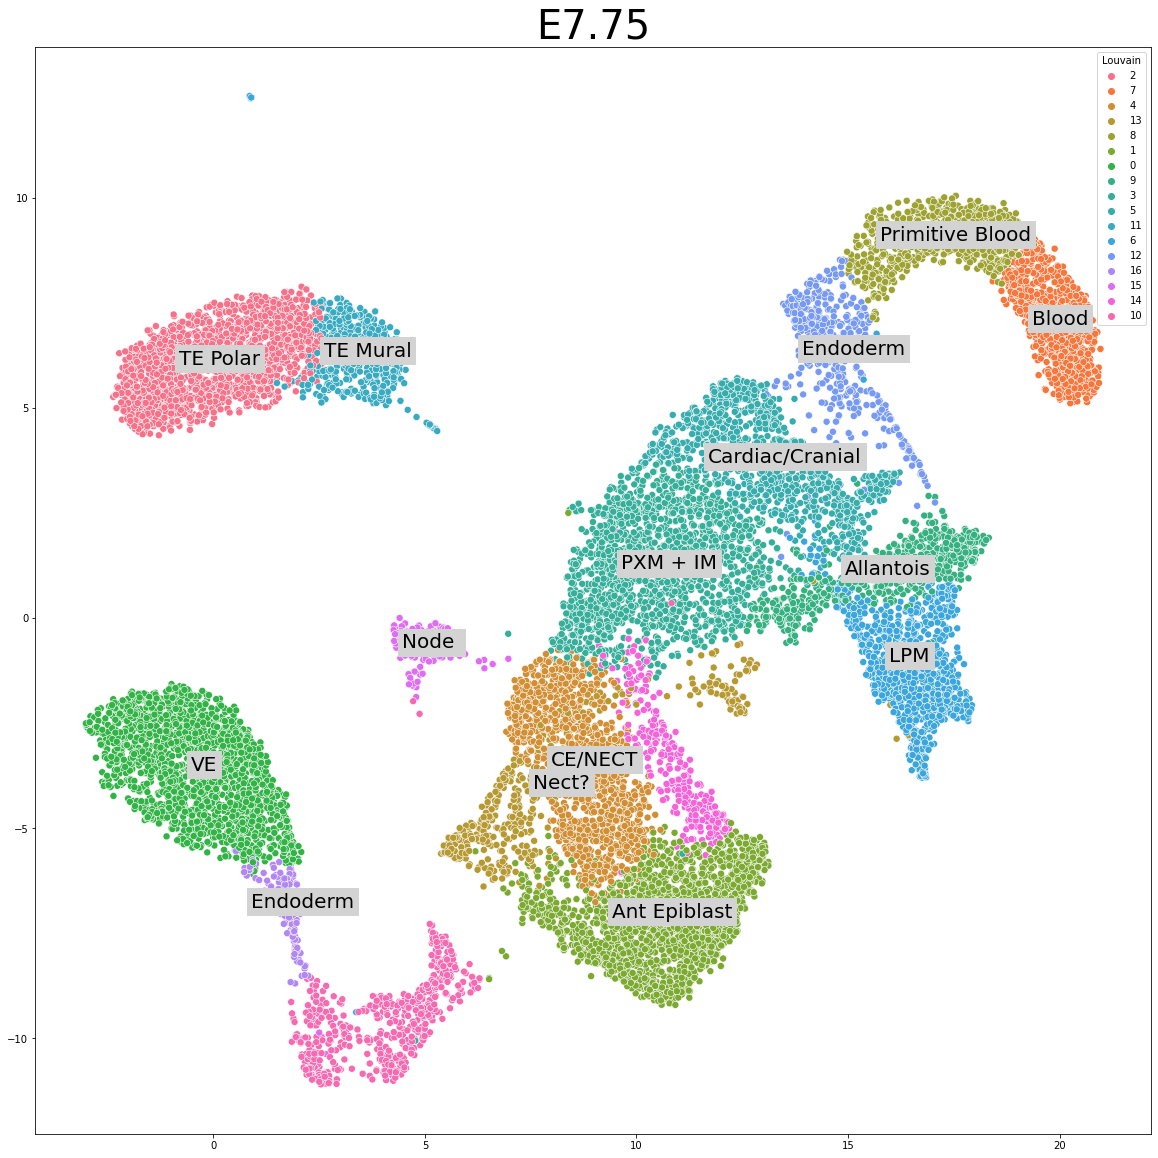

In [26]:
resolution = 1
for j,i in enumerate(a.obs["stage"].unique()[:]):
    
    try:
        names = pd.read_csv(i+".csv",sep=";")
        names.columns = ["Number","Name"]
        names.drop(0,inplace=True)
        names["Number"] = names["Number"].astype(int)
        names.set_index("Number",inplace=True)

        b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")   
        b.obs["Louvain"] = np.load("./ManipulatedData/"+par.METRIC+"/tables/clusters_louvain_r"+str(resolution)+"_"+i+".npy")
        b.obs["Louvain_Annotations"] = names.loc[b.obs["Louvain"].astype(int),"Name"].values 

        s = b.obs.groupby(["celltype","Louvain_Annotations"]).size().unstack()
        s = (s/s.sum(axis=0)).round(2)

        #fig,ax = plt.subplots(1,1,figsize=[20,20])
        sb.clustermap(s,annot=True)
        plt.savefig("Alfonso/Overlap"+i+".png")
        plt.close()
        
        #Plot clusters
        fig,ax = plt.subplots(1,1,figsize=[20,20])
        X = b.obsm["X_umap"]
        sb.scatterplot(X[:,0],X[:,1],hue=b.obs.loc[:,"Louvain"],s=50,ax=ax)
        ax.set_title(i,fontsize=40)
        for k in b.obs["Louvain"].unique():
            pos = b[b.obs["Louvain"]==k,:].obsm["X_umap"]
            pos = np.nan_to_num(pos)
            pos = pos.mean(axis=0)
            n = names.loc[int(k),"Name"]
            ax.text(pos[0]-0.1*len(n),pos[1],n,fontsize=20,backgroundcolor="lightgrey")
        fig.savefig("./Alfonso/Clustering_annotated_"+i+".png",bbox_inches="tight",transparent=False)
        plt.close(fig)    
        
    except:
        print("No annotations for :", i)

In [5]:
genes_comparative = ["Osr1","Tbx6","Foxf1"]
stages_comparative = {"E7.5":["3","4","7","10","11"],
                      "E8.0":["4","5","6"],
                      "E8.5":["1","2"]}

In [6]:
import itertools

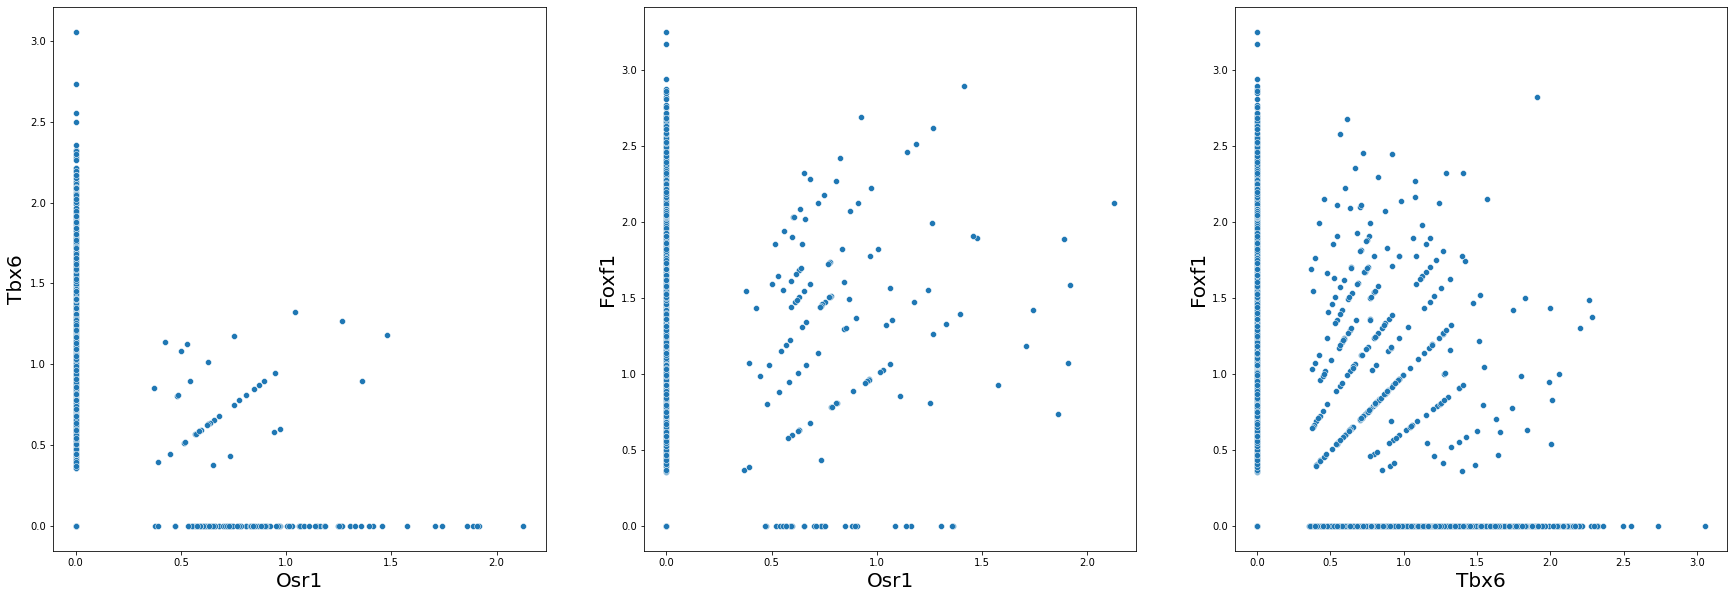

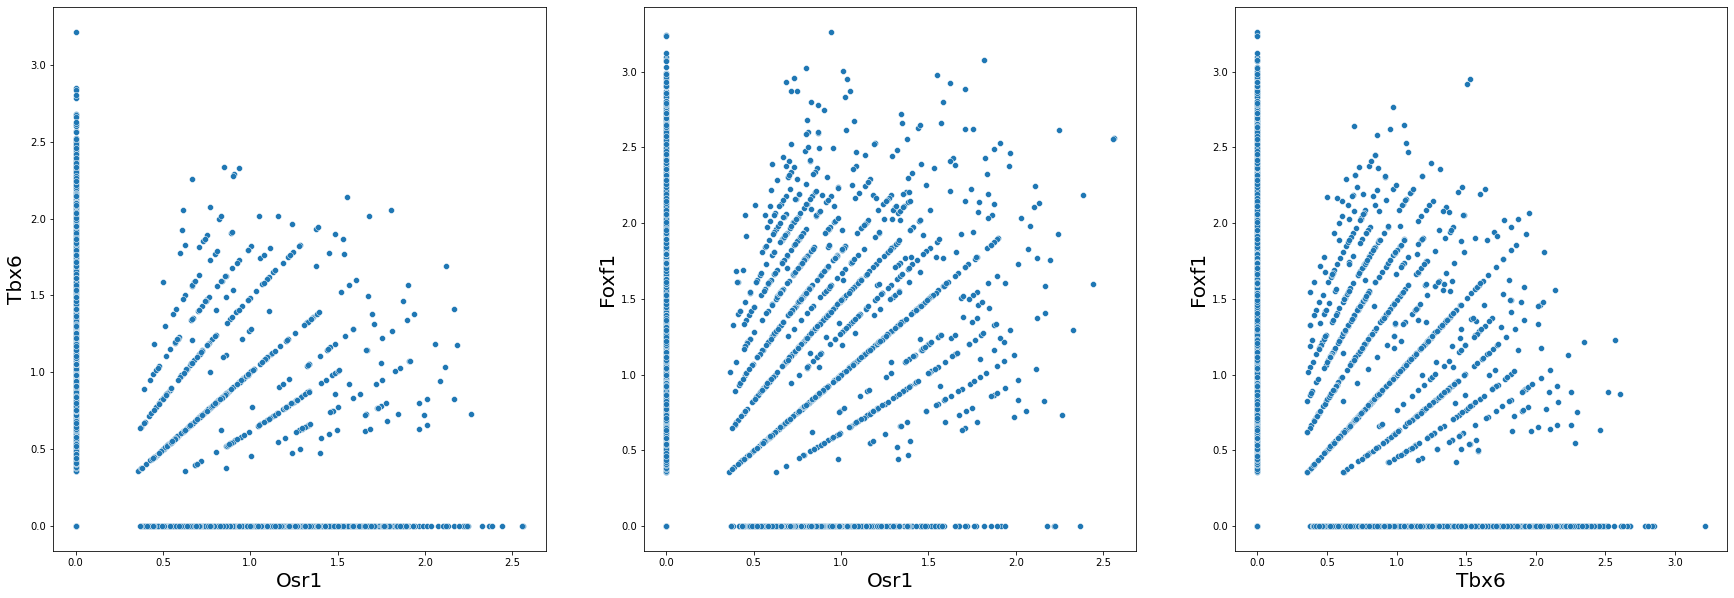

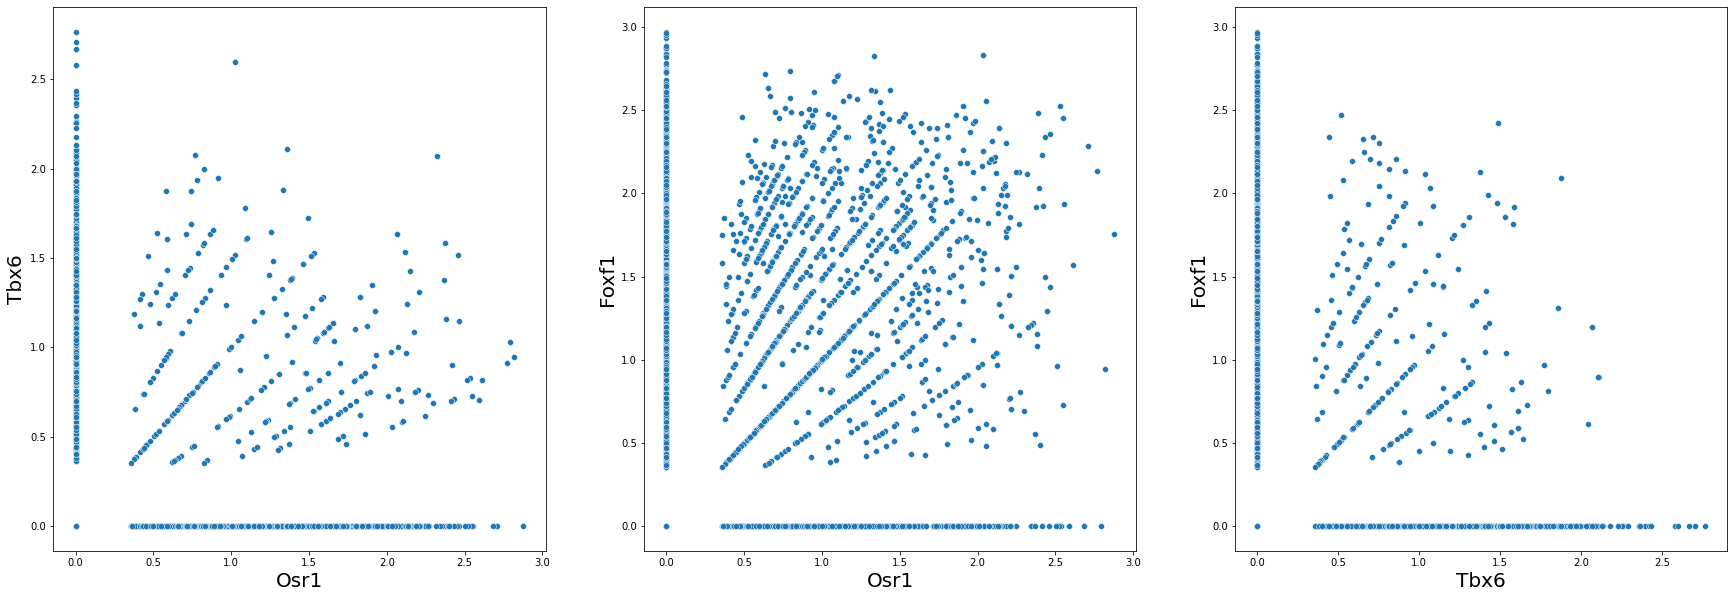

In [9]:
resolution = 1
for i in stages_comparative.keys():
    
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")   
    b.obs["Louvain"] = np.load("./ManipulatedData/"+par.METRIC+"/tables/clusters_louvain_r"+str(resolution)+"_"+i+".npy")

    red = [j in stages_comparative[i] for j in b.obs["Louvain"]]
    
    bred = b[red,:]
    
    fig, ax = plt.subplots(1,len(genes_comparative),figsize=[10*len(genes_comparative),10])
    for k,j in enumerate(itertools.combinations(genes_comparative,2)):
        x = b[:,b.var.loc[:,"Gene"]==j[0]].X.toarray()[:,0]
        y = b[:,b.var.loc[:,"Gene"]==j[1]].X.toarray()[:,0]
        sb.scatterplot(x,y,ax=ax[k])
        ax[k].set_xlabel(j[0],fontsize=20)
        ax[k].set_ylabel(j[1],fontsize=20)
    fig.savefig("./Alfonso/Overlapping/"+i+".png",bbox_inches="tight",transparent=False)
    #plt.close(fig)
    
    

In [29]:
resolution = 1
for j,i in enumerate(a.obs["stage"].unique()[:]):
    
    b = scp.read("ManipulatedData/"+par.METRIC+"/Doublets_after"+i+".h5ad")   
    b.obs["Louvain"] = np.load("./ManipulatedData/"+par.METRIC+"/tables/clusters_louvain_r"+str(resolution)+"_"+i+".npy")
        
        #Plot clusters
    for k,j in enumerate(itertools.combinations(genes_comparative,2)):    
        x = b[:,b.var.loc[:,"Gene"]==j[0]].X.toarray()[:,0] > 0
        y = b[:,b.var.loc[:,"Gene"]==j[1]].X.toarray()[:,0] > 0
        hue = x*y
        pos = np.argsort(hue)
        b.var.loc[:,"Gene"]==j[0]
        fig,ax = plt.subplots(1,1,figsize=[20,20])
        X = b.obsm["X_umap"]
        sb.scatterplot(X[pos,0],X[pos,1],hue=hue[pos],s=50,ax=ax)
        ax.set_title(j,fontsize=40)
        fig.savefig("./Alfonso/Coexpression/"+i+"_"+j[0]+"_"+j[1]+".png")
        plt.close(fig)

# DPC Clustering with tsne

For that we will use the clustering as described by [this paper](https://science.sciencemag.org/content/sci/344/6191/1492.full.pdf) and [this implementation](https://github.com/cwehmeyer/pydpc).

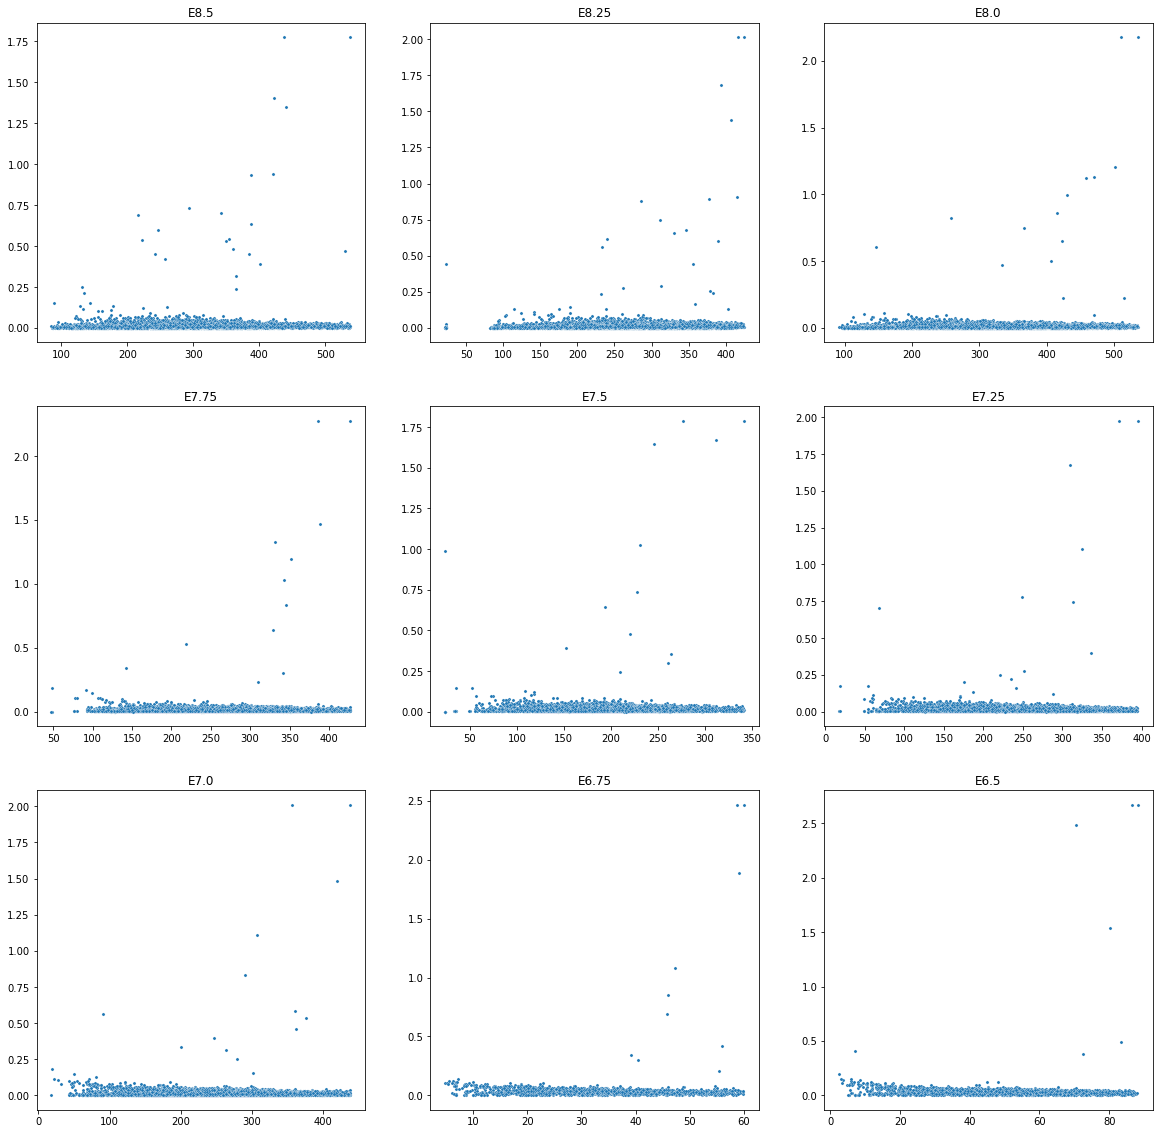

In [67]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

c = []
for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/tsne_"+i+".npy")
    
    X_proc = preprocessing.StandardScaler().fit_transform(X)
    cluster = pydpc.Cluster(X_proc,autoplot=False);
    c.append(cluster)
        
    sb.scatterplot(cluster.density,cluster.delta,s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    

In [68]:
cut = \
[
[180,0.25],    
[180,0.25],    
[180,0.25],    
[180,0.25],    
[180,0.25],    
[180,0.25],    
[180,0.25],    
[30,0.25],    
[30,0.25]
]

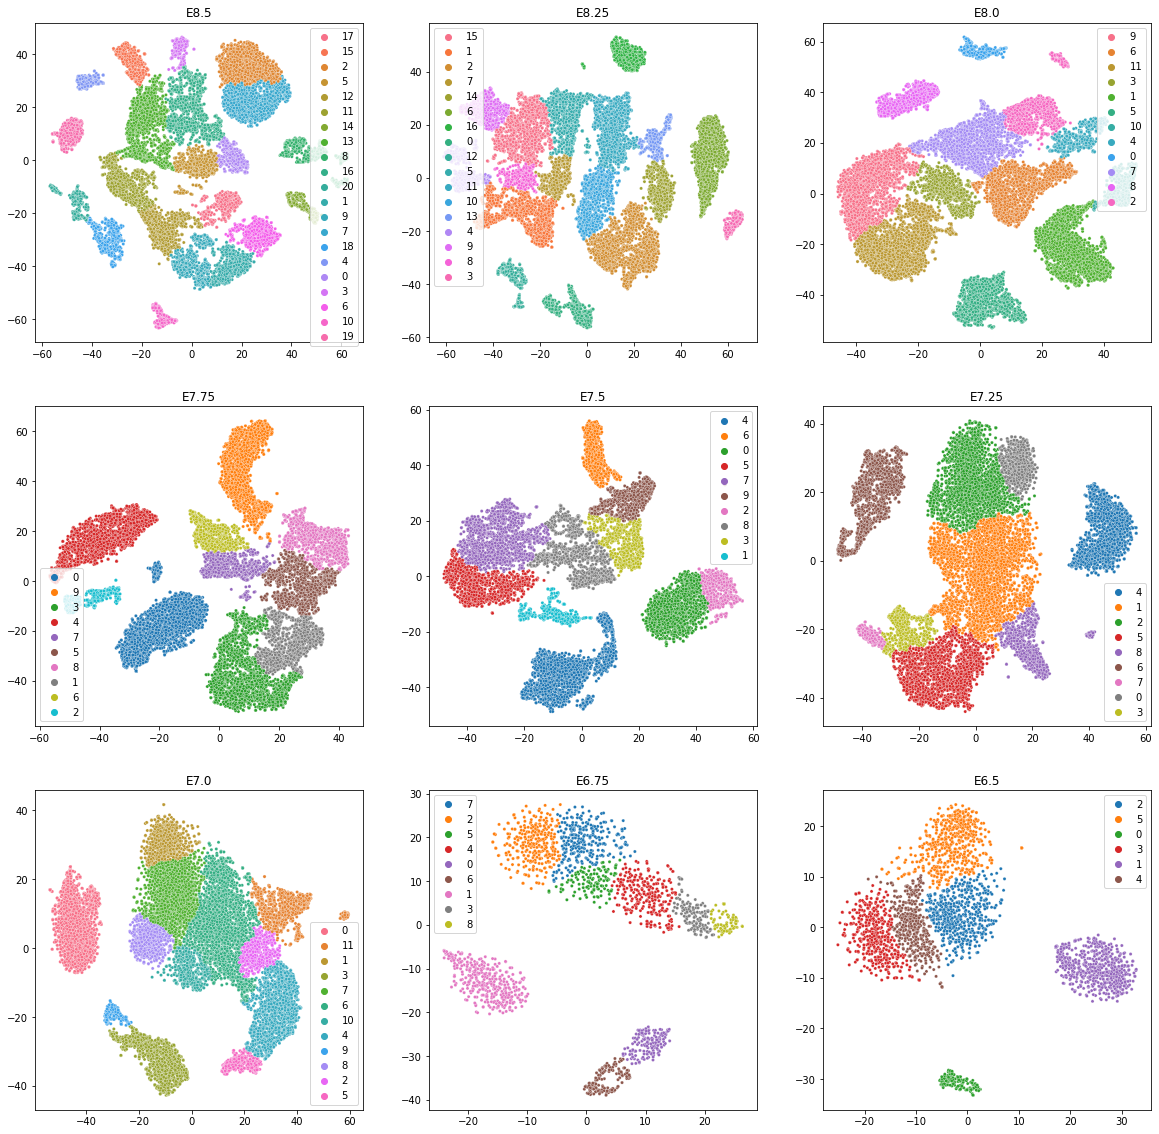

In [69]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/tsne_"+i+".npy")
    
    c[j].assign(cut[j][0],cut[j][1])
    
    np.save("./ManipulatedData/"+par.METRIC+"/tables/clusters_dpc_tsne_"+i+".npy",c[j].membership.astype(str))
    
    sb.scatterplot(X[:,0],X[:,1],hue=c[j].membership.astype(str),s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    
fig.savefig("./Plots/Clusterings/Clustering_by_tsne_stages_tsne.png",bbox_inches="tight",transparent=True)

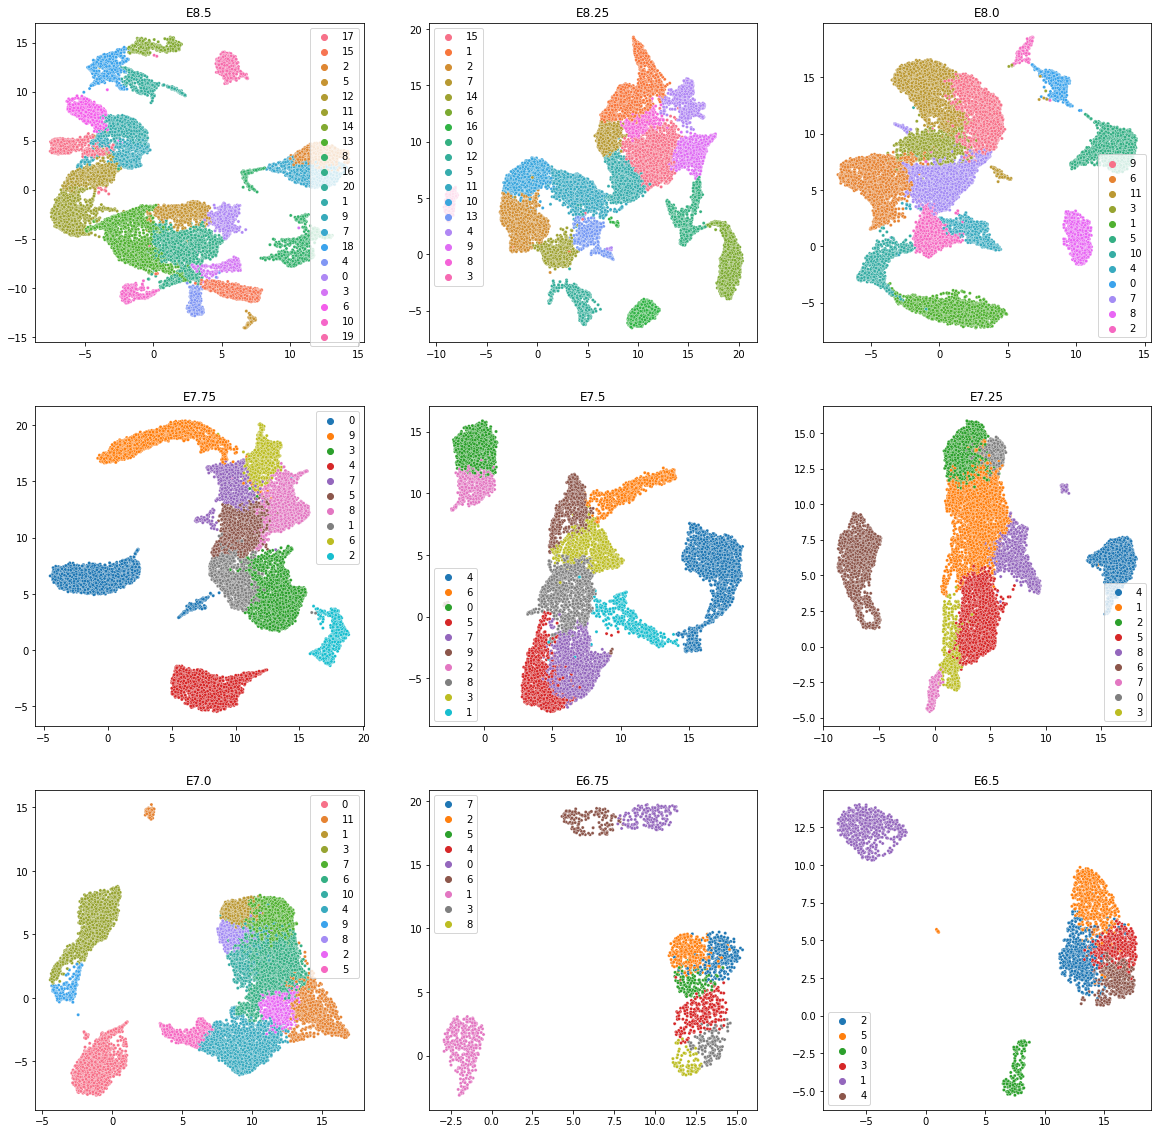

In [70]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/umap_"+i+".npy")
    
    sb.scatterplot(X[:,0],X[:,1],hue=c[j].membership.astype(str),s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    
fig.savefig("./Plots/Clusterings/Clustering_by_tsne_stages_umap.png",bbox_inches="tight",transparent=True)

# DPC Clustering with umap

For that we will use the clustering as described by [this paper](https://science.sciencemag.org/content/sci/344/6191/1492.full.pdf) and [this implementation](https://github.com/cwehmeyer/pydpc).

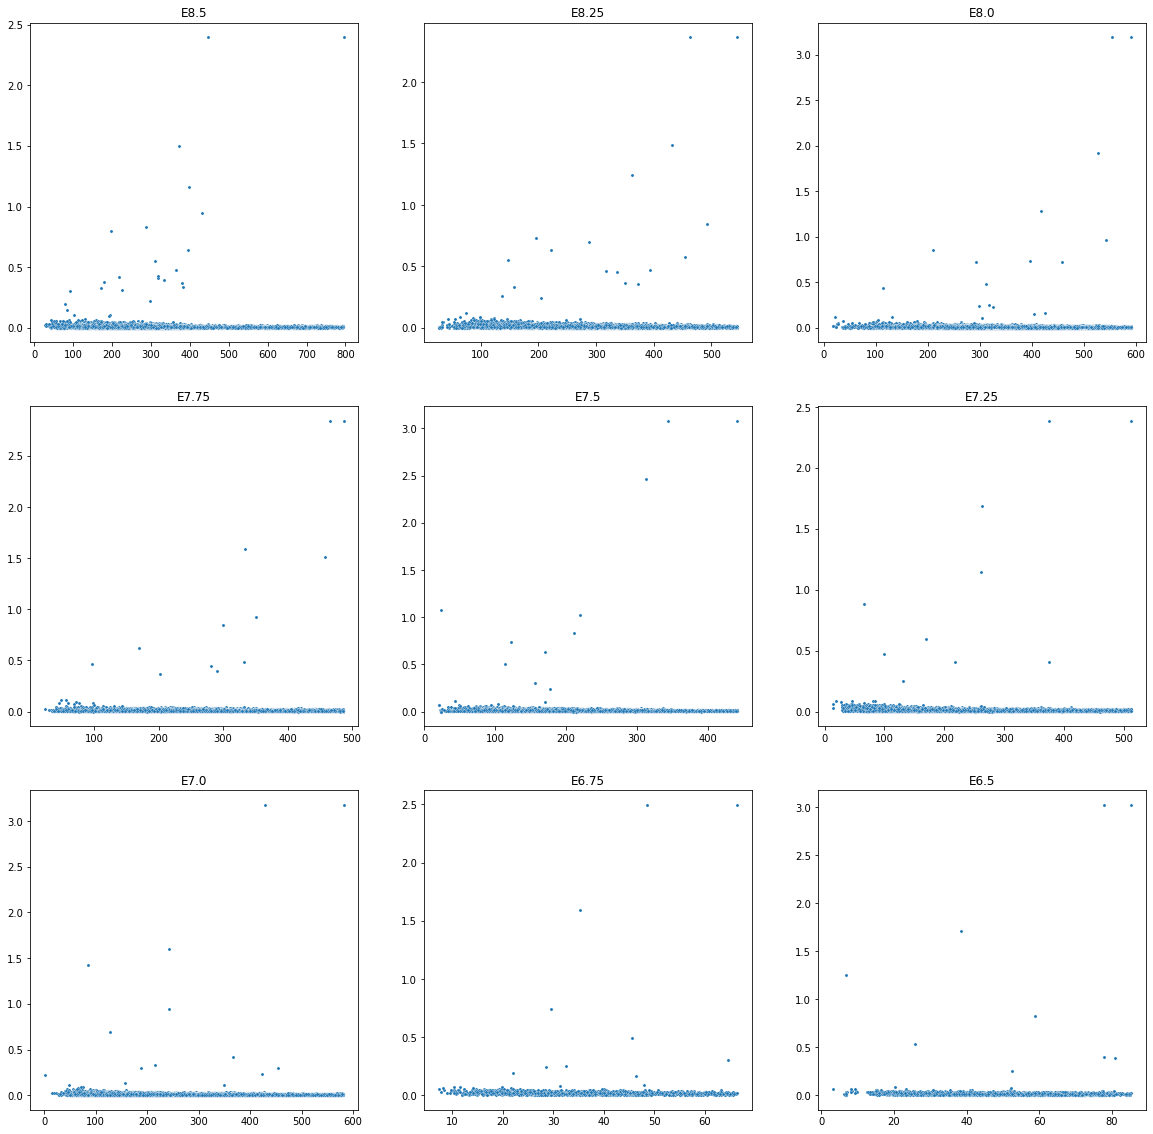

In [71]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

c = []
for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/umap_"+i+".npy").copy(order='C').astype("float64")
    
    X_proc = preprocessing.StandardScaler().fit_transform(X)
    cluster = pydpc.Cluster(X_proc,autoplot=False);
    c.append(cluster)
        
    sb.scatterplot(cluster.density,cluster.delta,s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    

In [72]:
cut = \
[
[100,0.15],    
[100,0.15],    
[100,0.15],    
[100,0.15],    
[100,0.15],    
[100,0.15],    
[100,0.15],    
[20,0.15],    
[20,0.15]
]

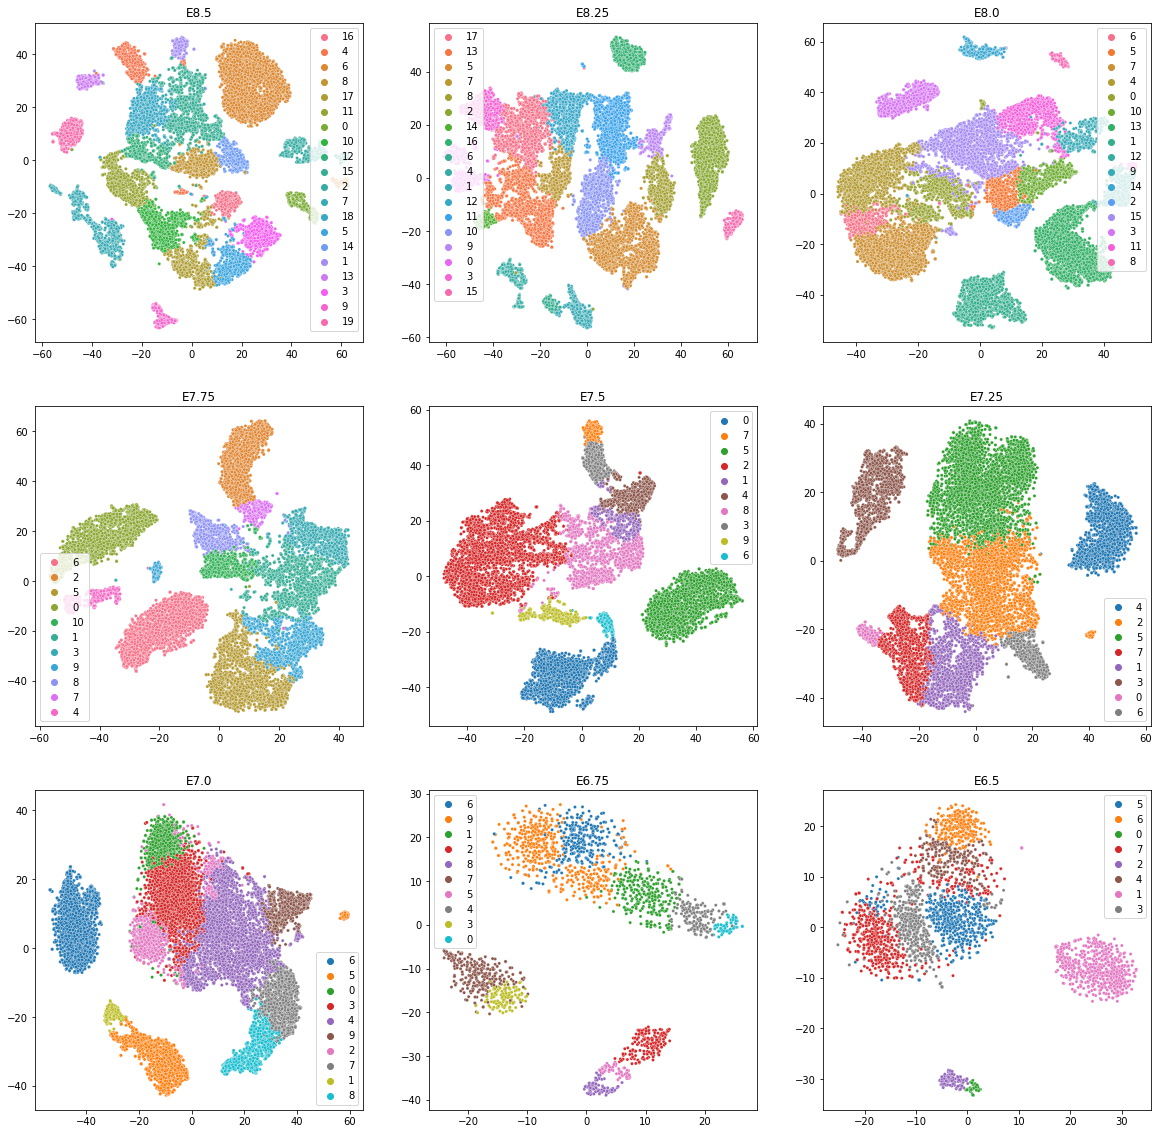

In [73]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/tsne_"+i+".npy")
    
    c[j].assign(cut[j][0],cut[j][1])
    
    np.save("./ManipulatedData/"+par.METRIC+"/tables/clusters_dpc_umap_"+i+".npy",c[j].membership.astype(str))
    
    sb.scatterplot(X[:,0],X[:,1],hue=c[j].membership.astype(str),s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    
fig.savefig("./Plots/Clusterings/Clustering_by_umap_stages_tsne.png",bbox_inches="tight",transparent=True)

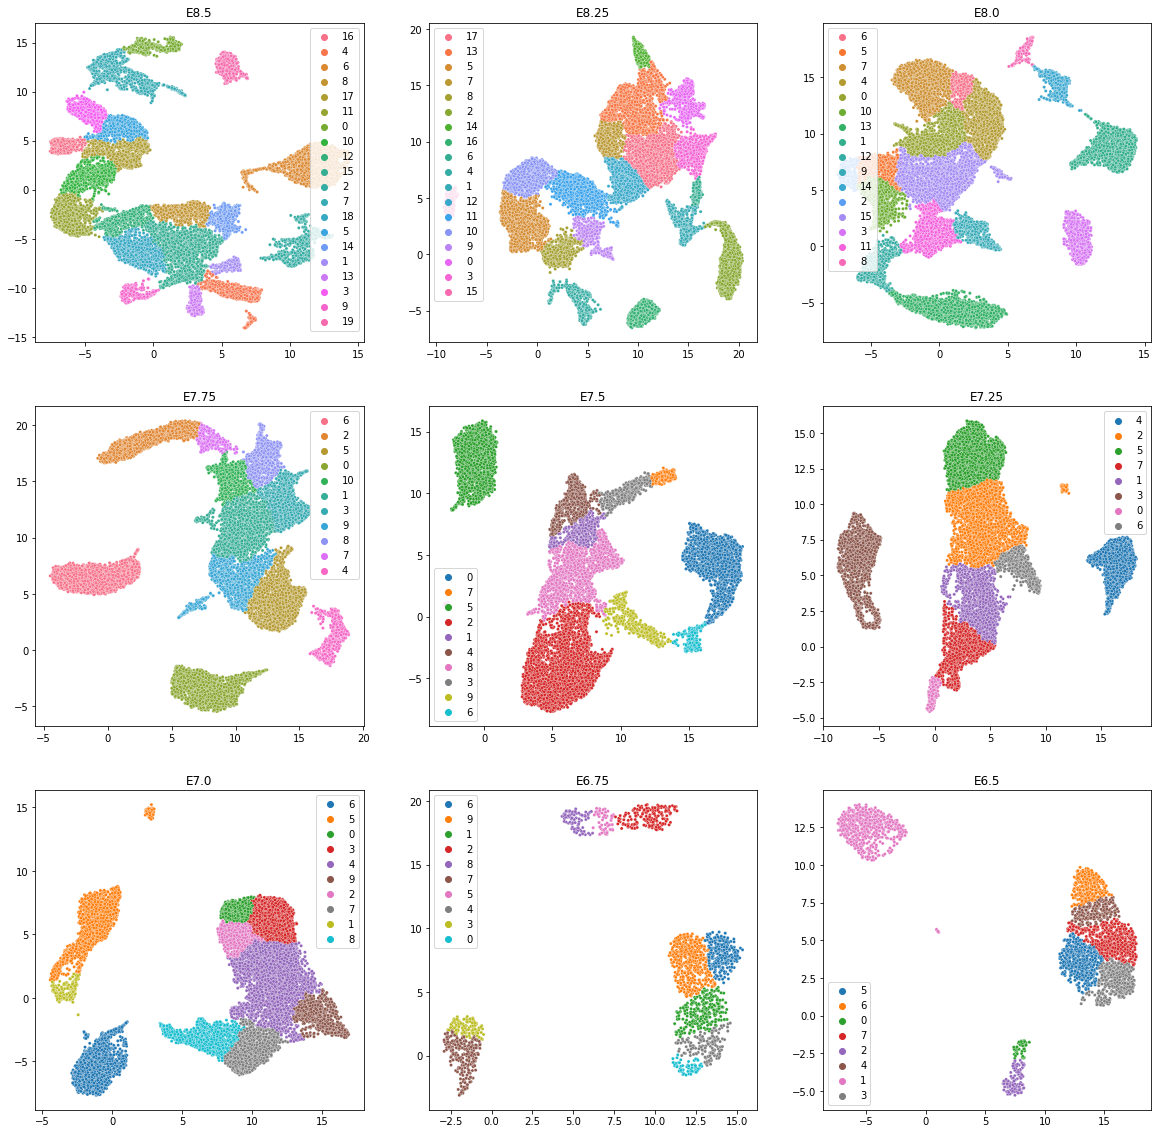

In [74]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/umap_"+i+".npy")
    
    sb.scatterplot(X[:,0],X[:,1],hue=c[j].membership.astype(str),s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    
fig.savefig("./Plots/Clusterings/Clustering_by_umap_stages_umap.png",bbox_inches="tight",transparent=True)

# DPCcustering with Harmony PCs

The algorithm clearly fails with high dimensions as in this case there is not clear dense regions and the cells are very connected. This approach hence only works with embedings already defined by tnse or umap.

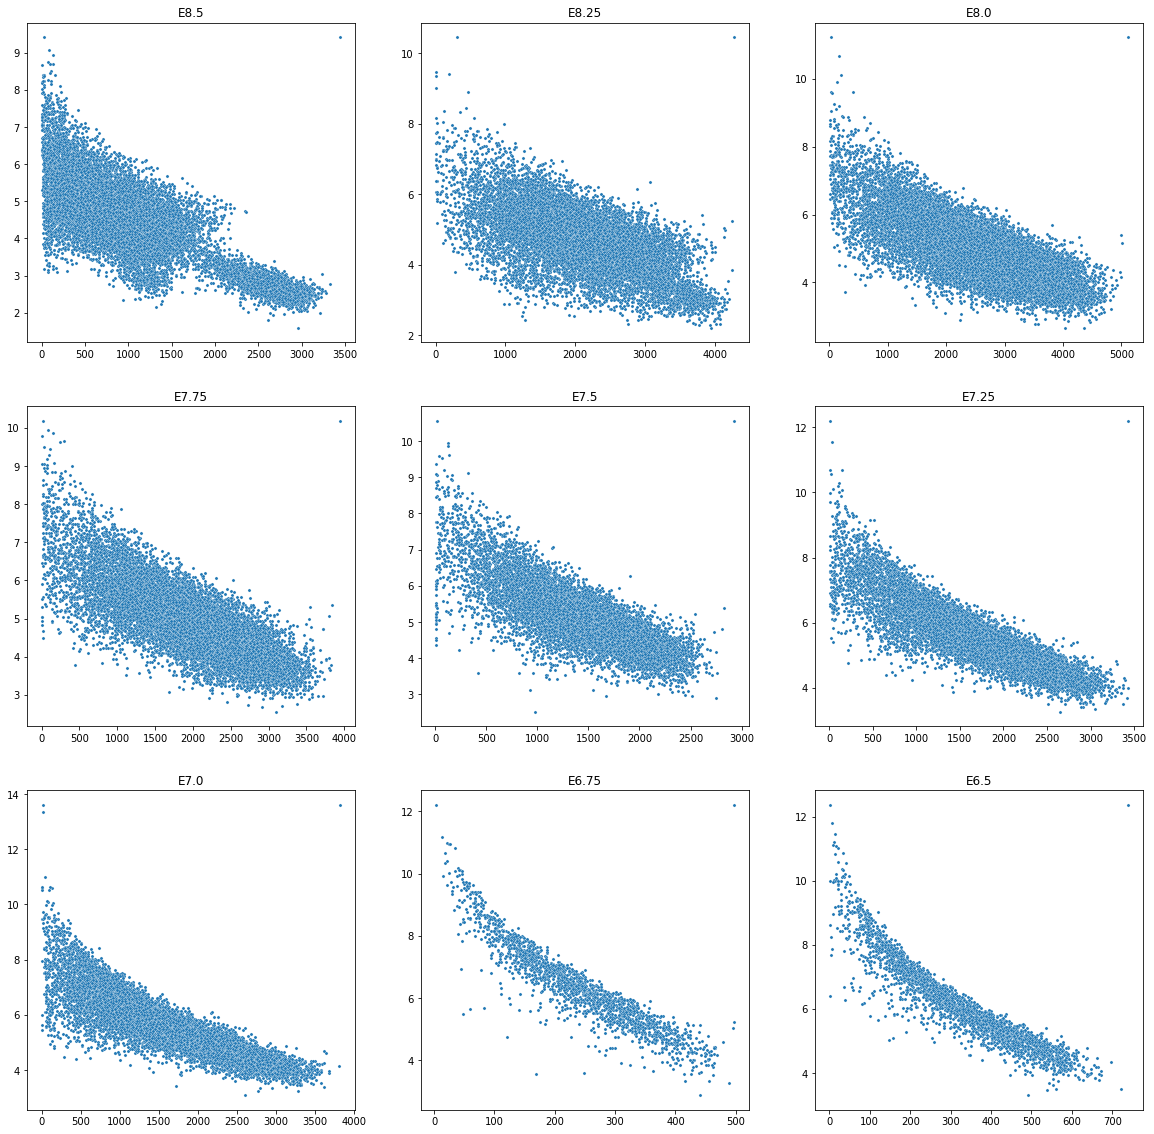

In [75]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

c = []
for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/harmony_pca_"+i+".npy")
    
    X_proc = preprocessing.StandardScaler().fit_transform(X).copy(order='C').astype("float64")
    cluster = pydpc.Cluster(X_proc,autoplot=False);
    c.append(cluster)
        
    sb.scatterplot(cluster.density,cluster.delta,s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    

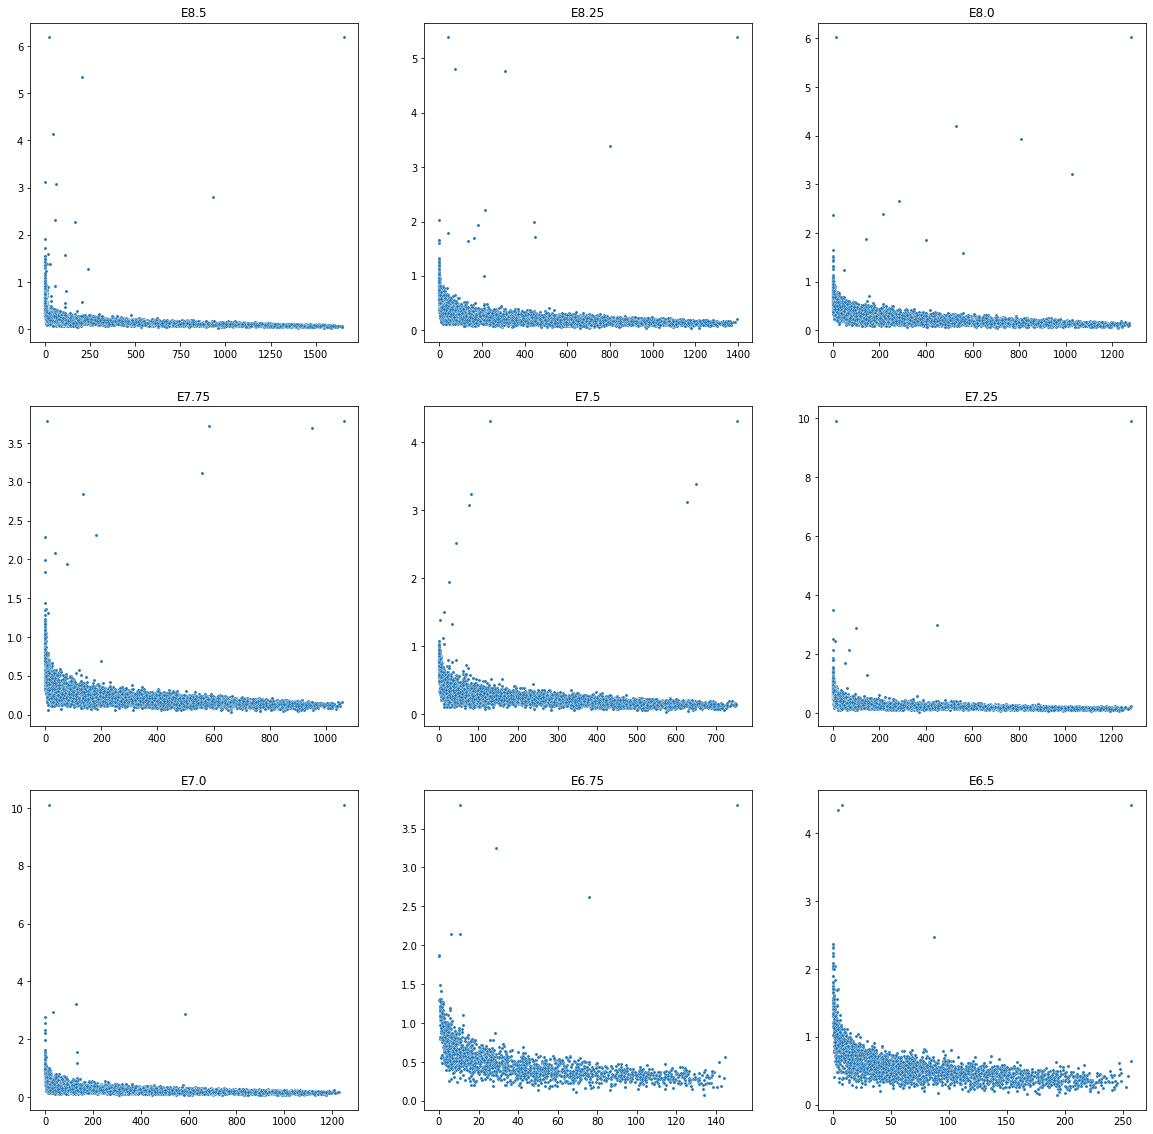

In [76]:
fig,ax = plt.subplots(3,3,figsize=[20,20])

c = []
for j,i in enumerate(a.obs["stage"].unique()):
    
    posx = j//3
    posy = j%3
    
    X = np.load("./ManipulatedData/"+par.METRIC+"/tables/harmony_pca_"+i+".npy")
    
    X_proc = preprocessing.StandardScaler().fit_transform(X)[:,:7].copy(order='C').astype("float64")
    cluster = pydpc.Cluster(X_proc,autoplot=False);
    c.append(cluster)
        
    sb.scatterplot(cluster.density,cluster.delta,s=10,ax=ax[posx,posy])
    ax[posx,posy].set_title(i)
    